## Imports

In [ ]:
import kagglehub
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Downloading Data

In [ ]:
import io
import kagglehub
from datetime import datetime
from pathlib import Path

In [ ]:
path = Path(kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data"))
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'daily-climate-time-series-data' dataset.
Path to dataset files: /kaggle/input/daily-climate-time-series-data


In [ ]:
train_ds = pd.read_csv(path / 'DailyDelhiClimateTrain.csv')
test_ds = pd.read_csv(path / 'DailyDelhiClimateTest.csv')


## Utils


In [ ]:
from scipy.stats import spearmanr

def plot_bivariate_scatter(data, lag=0, size=(10,8)):
    """
    Plots a matrix of bivariate scatter plots for the columns of a DataFrame.
    The main diagonal shows histograms, the lower triangle shows scatter plots
    with an optional lag, and the upper triangle shows Spearman correlation coefficients.
    Variable names are placed on the extreme left and bottom axes, and axis ticks are shown.

    Args:
        data (pd.DataFrame): The DataFrame containing the variables to plot.
        lag (int): The lag to apply to the x-axis variable in the lower triangle scatter plots.
    """

    vars_to_plot = data.columns
    num_vars = len(vars_to_plot)

    fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=size)
    fig.suptitle(f"Bivariate Scatter Matrix (Lag = {lag})", fontsize=16, fontweight='bold', y=1.02)

    for i in range(num_vars):
        for j in range(num_vars):
            var1 = vars_to_plot[i]
            var2 = vars_to_plot[j]

            # ==== Diagonal: histograma ====
            if i == j:
                axes[i, j].hist(data[var1].dropna(), bins=20)
                axes[i, j].set_title('')

            # ==== Triângulo inferior: scatter (sem regressão) ====
            elif i > j:
                lagged_var1 = data[var1].shift(lag).dropna()

                if lag > 0:
                    aligned_var2 = data[var2].iloc[lag:].dropna()
                else:
                    aligned_var2 = data[var2].dropna()

                common_index = lagged_var1.index.intersection(aligned_var2.index)

                lagged_var1_aligned = lagged_var1.loc[common_index]
                aligned_var2_aligned = aligned_var2.loc[common_index]

                if not lagged_var1_aligned.empty and not aligned_var2_aligned.empty:
                    axes[i, j].scatter(
                        lagged_var1_aligned,
                        aligned_var2_aligned,
                        alpha=0.5
                    )

                    # 🔹 Texto indicando qual variável foi lagada
                    axes[i, j].text(
                        0.05, 0.9,
                        f"{var1}\n(Lag = {lag})",
                        transform=axes[i, j].transAxes,
                        fontsize=8.5,
                        color='darkgreen',
                        ha='left',
                        va='top',
                        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.6)
                    )

            # ==== Triângulo superior: Spearman ====
            elif i < j:

                if lag > 0:
                    corr_data = pd.DataFrame({
                        var1: data[var1].shift(lag),
                        var2: data[var2].iloc[lag:]
                    }).dropna()
                else:
                    corr_data = data[[var1, var2]].dropna()

                if len(corr_data) > 1:
                    corr_coef, _ = spearmanr(corr_data[var1], corr_data[var2])

                    axes[i, j].text(
                        0.5, 0.5,
                        f"ρ = {corr_coef:.2f}",
                        ha='center',
                        va='center',
                        fontsize=12,
                        color='blue',
                        transform=axes[i, j].transAxes
                    )
                else:
                    axes[i, j].text(
                        0.5, 0.5,
                        'Not enough data',
                        ha='center',
                        va='center',
                        fontsize=10,
                        color='red',
                        transform=axes[i, j].transAxes
                    )

                axes[i, j].axis('off')

            # ==== Rótulos nas bordas ====
            if j == 0:
                axes[i, j].set_ylabel(var1, rotation=90, size='large')
            if i == num_vars - 1:
                axes[i, j].set_xlabel(var2, size='large')

    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

def plot_pairwise_crosscorrelations(data, max_lag=30):
    """
    Calcula e plota a cross-correlation function (CCF) entre todas as combinações 2 a 2 de variáveis numéricas.

    Args:
        data (pd.DataFrame): dataset contendo as variáveis numéricas.
        max_lag (int): número máximo de defasagens a considerar.
    """
    # Seleciona apenas colunas numéricas
    num_cols = data.select_dtypes(include=np.number).columns
    num_pairs = len(num_cols)

    # Loop 2 a 2
    for i in range(num_pairs):
        for j in range(i+1, num_pairs):
            var1 = num_cols[i]
            var2 = num_cols[j]

            # Remove NaNs
            x = data[var1].dropna()
            y = data[var2].dropna()
            min_len = min(len(x), len(y))
            x, y = x.iloc[:min_len], y.iloc[:min_len]

            # Calcula CCF usando statsmodels
            corr_vals = ccf(x - np.mean(x), y - np.mean(y))[:max_lag+1]
            lags = np.arange(0, max_lag+1)

            # Plot
            plt.figure(figsize=(8, 4))
            plt.bar(lags, corr_vals, width=0.4, color='royalblue')
            plt.axhline(0, color='black', linewidth=1)
            plt.title(f"Cross-Correlation Function: {var1} vs {var2}", fontsize=12)
            plt.xlabel("Lag (k)")
            plt.ylabel("CCF")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()


In [ ]:
from scipy.stats import median_abs_deviation

# calcula o robust z-score
def robust_zscore(series):
    median = np.median(series)
    mad = median_abs_deviation(series, scale='normal')  # já inclui o fator 1.4826
    return (series - median) / mad


## Exploratory Data Analysis

### Visão geral dos dados

In [ ]:
train_ds.head()

date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

In [ ]:
print('--- Train Dataset Dates ---')
print(f"Start Date: {train_ds['date'].min()}")
print(f"End Date: {train_ds['date'].max()}")
print(f"Number of days: {train_ds['date'].nunique()}")

print('\n--- Test Dataset Dates ---')
print(f"Start Date: {test_ds['date'].min()}")
print(f"End Date: {test_ds['date'].max()}")
print(f"Number of days: {test_ds['date'].nunique()}")

--- Train Dataset Dates ---
Start Date: 2013-01-01
End Date: 2017-01-01
Number of days: 1462

--- Test Dataset Dates ---
Start Date: 2017-01-01
End Date: 2017-04-24
Number of days: 114


In [ ]:
train_ds.shape

(1462, 5)

In [ ]:
train_ds['date'] = pd.to_datetime(train_ds['date'])
test_ds['date'] = pd.to_datetime(test_ds['date'])

In [ ]:
train_ds.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

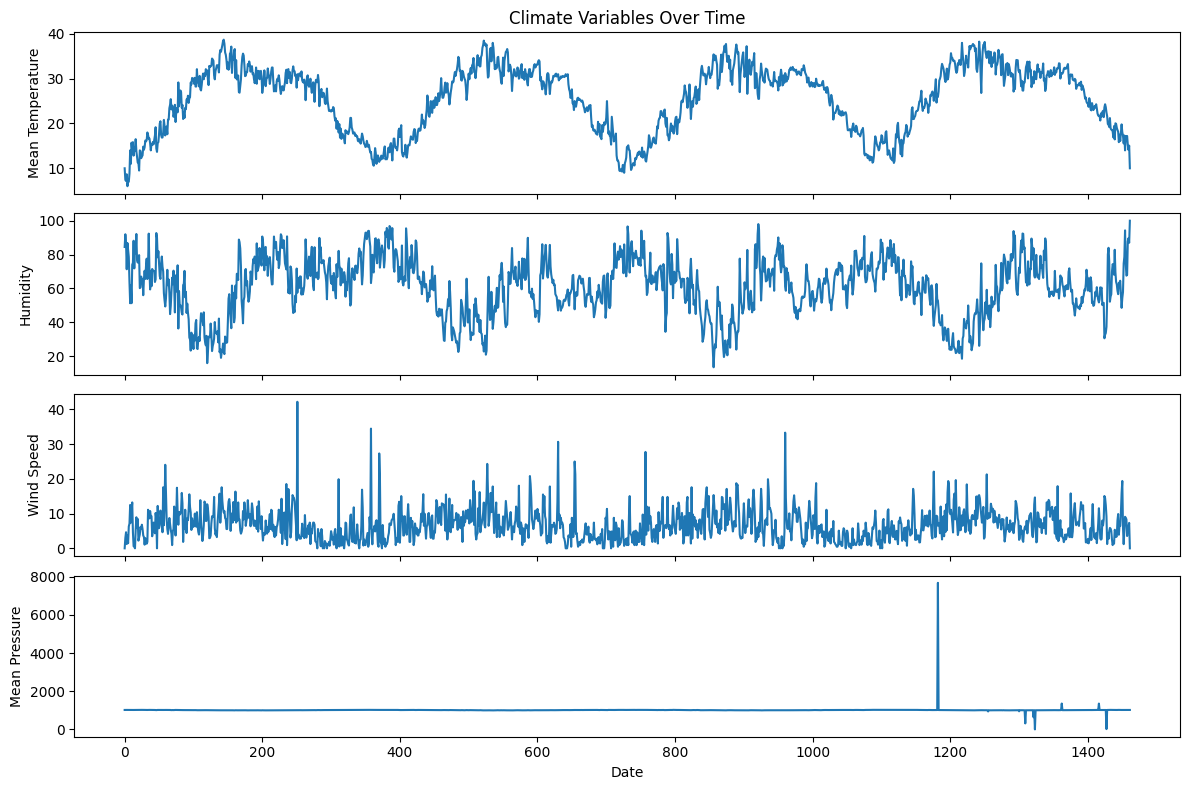

In [ ]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(12, 8),
    sharex=True
)

axes[0].plot(train_ds.index, train_ds['meantemp'])
axes[0].set_ylabel('Mean Temperature')
axes[0].set_title('Climate Variables Over Time')

axes[1].plot(train_ds.index, train_ds['humidity'])
axes[1].set_ylabel('Humidity')

axes[2].plot(train_ds.index, train_ds['wind_speed'])
axes[2].set_ylabel('Wind Speed')

axes[3].plot(train_ds.index, train_ds['meanpressure'])
axes[3].set_ylabel('Mean Pressure')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()


A Figura apresenta as séries temporais. Observa-se que a temperatura média
apresenta variações periódicas bem definidas, indicando forte
componente sazonal.

A umidade e a pressão atmosférica exibem padrões mais instáveis ao
longo do tempo, enquanto a velocidade do vento apresenta maior
variabilidade. Esses comportamentos distintos justificam a análise individual das séries antes da modelagem.


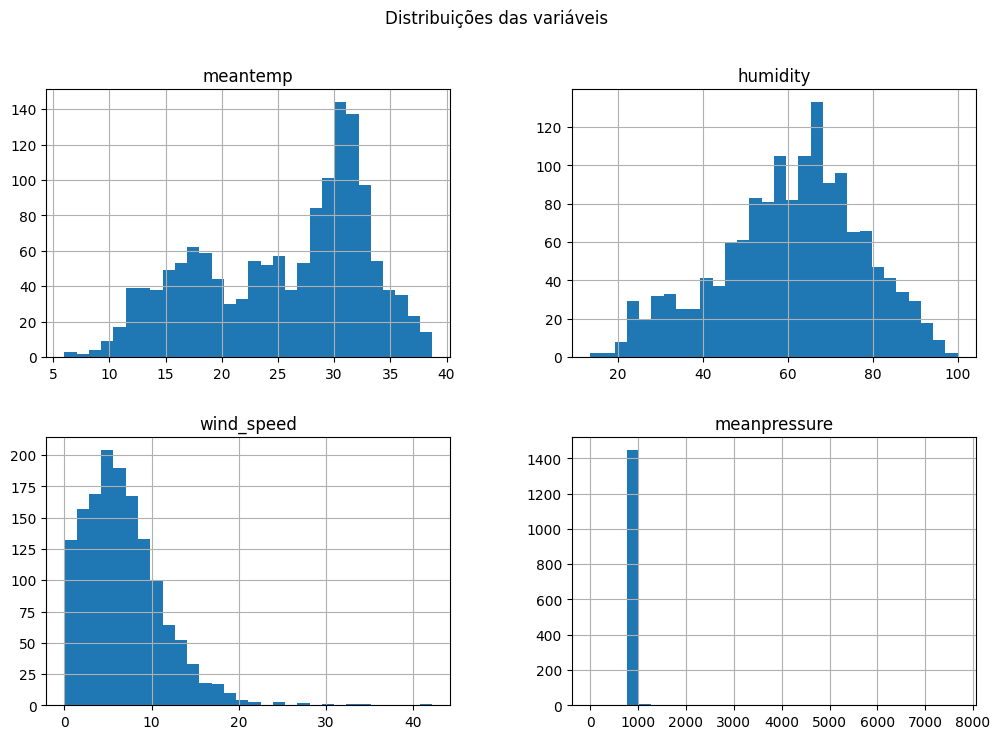

In [ ]:
train_ds.drop('date', axis=1).hist(figsize=(12,8), bins=30)
plt.suptitle("Distribuições das variáveis")
plt.show()


In [ ]:
train_ds.drop('date', axis=1).describe()

meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333

In [ ]:
print(f'Curtose: {train_ds['meanpressure'].kurtosis()}\nAssimetria: {train_ds['meanpressure'].skew()}')


Curtose: 1286.3267279096426
Assimetria: 34.43588657251546


meanpressure possui valores negativos ou grandes demais, possíveis erros; Uma análise será necessária

Esses valores estão aumentando a curtose e dificultando a visualização da verdadeira série.


In [ ]:
# Check the frequency of the data by looking at the difference between consecutive dates
time_diff = train_ds['date'].diff().mode()
print(f"Typical time difference between observations (frequency): {time_diff[0]}")

# Get the start and end dates
start_date = train_ds['date'].min()
end_date = train_ds['date'].max()

print(f"Start date of observations: {start_date}")
print(f"End date of observations: {end_date}")

Typical time difference between observations (frequency): 1 days 00:00:00
Start date of observations: 2013-01-01 00:00:00
End date of observations: 2017-01-01 00:00:00


In [ ]:
train_ds['date'].diff().value_counts()

date
1 days    1461
Name: count, dtype: int64

sem buracos temporais

## Detecção de Outliers


robust Z-score para encontrar os outliers

* Não supõe normalidade
* lida bem com distribuições aproximadamente simétricas
* lida bem com distribuições com caudas longas/pesadas (meanpressure)
* Usa estatísticas robustas (median e median_abs_deviation)


In [ ]:
# meanpressure
z1 = robust_zscore(train_ds['meanpressure'])
outliers_meanpressure = train_ds[np.abs(z1) > 3.5]
outliers_meanpressure['meanpressure']

1182    7679.333333
1255     938.066667
1300     946.312500
1309     310.437500
1321     633.900000
1323      -3.041667
1362    1352.615385
1416    1350.296296
1427      12.045455
Name: meanpressure, dtype: float64

A forte assimetria e alta curtose de meanpressure é causada pelos próprios valores anômalos, pois são distantes e acabam distorcendo e inflando esses valores. O robust z-score é bom para esse tipo de situação (assimetria e alta curtose causada por causa dos valores discrepantes) pois a mediana continua representando o "verdadeiro centro" da distriuição e o MAD, a "verdadeira dispersão".

In [ ]:
# humidity
z1 = robust_zscore(train_ds['humidity'])
outliers_humidity = train_ds[np.abs(z1) > 3.5]
outliers_humidity['humidity']

Series([], Name: humidity, dtype: float64)

In [ ]:
# wind_speed
z1 = robust_zscore(train_ds['wind_speed'])
outliers_wind_speed = train_ds[np.abs(z1) > 3.5]
outliers_wind_speed['wind_speed']

59      24.066667
251     42.220000
358     34.487500
370     27.337500
527     24.325000
630     30.685714
654     25.012500
655     21.300000
757     27.775000
960     33.325000
1176    22.100000
1253    21.306250
Name: wind_speed, dtype: float64

In [ ]:
train_ds['wind_speed'].describe(percentiles=[.9, .95, .99, .995, .999])


count    1462.000000
mean        6.802209
std         4.561602
min         0.000000
50%         6.221667
90%        12.608125
95%        14.812500
99%        19.912500
99.5%      24.246208
99.9%      33.951588
max        42.220000
Name: wind_speed, dtype: float64

esses valores fazem parte da variabilidade natural de wind_speed... Não consideramos que são erros

In [ ]:
# meantemp
z1 = robust_zscore(train_ds['meantemp'])
outliers_meantemp = train_ds[np.abs(z1) > 3.5]
outliers_meantemp['meantemp']

Series([], Name: meantemp, dtype: float64)

## Remoção de outliers

In [ ]:

train_ds2 = train_ds.copy()

# identificar colunas numéricas (excluindo a temporal)
num_cols = train_ds2.select_dtypes(include=['float64', 'int64']).columns

# nas linhas com outliers, transformar os valores numéricos em NaN
train_ds2.loc[outliers_meanpressure.index, num_cols] = np.nan

# interpolar as colunas numéricas (polinomio de grau 3)
train_ds2[num_cols] = train_ds2[num_cols].interpolate(method='polynomial', order=3)


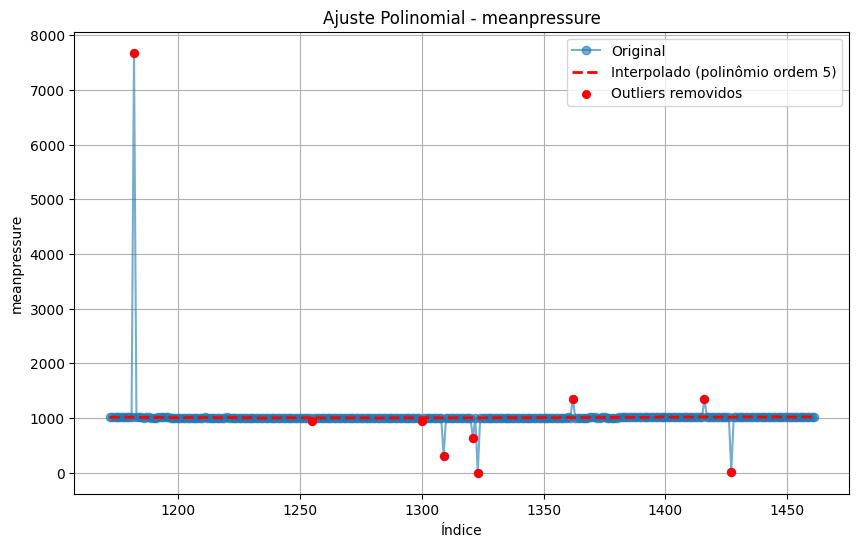

In [ ]:
# Coluna a ser analisada
col = 'meanpressure'

# Índices dos outliers
out_idx = outliers_meanpressure.index

# Escolher uma janela em torno dos outliers para visualização
# (por exemplo, 10 pontos antes e depois do primeiro outlier)
i0 = out_idx[0]
window = range(max(0, i0 - 10), len(train_ds2))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(window, train_ds[col].iloc[window], 'o-', label='Original', alpha=0.6)
plt.plot(window, train_ds2[col].iloc[window], 'r--', label='Interpolado (polinômio ordem 5)', linewidth=2)

# Destacar os outliers
plt.scatter(out_idx, train_ds[col].iloc[out_idx], color='red', s=30, label='Outliers removidos', zorder=5)

plt.title(f"Ajuste Polinomial - {col}")
plt.xlabel("Índice")
plt.ylabel(col)
plt.legend()
plt.grid(True)
plt.show()




Após a identificação de outliers, substituímos os valores extremos por valores ausentes (NaN) e, em seguida, aplicar interpolação polinomial de ordem 3 nas variáveis numéricas.

Isso permite uma estimativa suave dos valores ausentes, sendo adequado para séries temporais contínuas, desde que as lacunas sejam relativamente curtas.

Ressalta-se que os valores interpolados representam estimativas e não observações reais, sendo utilizados com o objetivo de reduzir o impacto de ruídos e inconsistências na análise exploratória e nas etapas subsequentes de modelagem.


### Teste de estacionariedade

* ADF : H_0 : A série é não estacionária
* KPSS : H_0 : A série é estacionária

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(series, name=""):
    series = series.dropna()

    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c', nlags='auto')

    print(f"\nResultados para: {name}")

    print("\nADF Test:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")

    print("\nKPSS Test:")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")


In [ ]:
stationarity_tests(train_ds2['meanpressure'], "meanpressure")


Resultados para: meanpressure

ADF Test:
ADF Statistic: -2.1555
p-value: 0.2228

KPSS Test:
KPSS Statistic: 0.0940
p-value: 0.1000


/tmp/ipython-input-3187613491.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [ ]:
stationarity_tests(train_ds2['meantemp'], "meantemp")


Resultados para: meantemp

ADF Test:
ADF Statistic: -2.0216
p-value: 0.2772

KPSS Test:
KPSS Statistic: 0.1890
p-value: 0.1000


/tmp/ipython-input-3187613491.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [ ]:
stationarity_tests(train_ds2['humidity'], "humidity")


Resultados para: humidity

ADF Test:
ADF Statistic: -3.6822
p-value: 0.0044

KPSS Test:
KPSS Statistic: 0.0934
p-value: 0.1000


/tmp/ipython-input-3187613491.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [ ]:
stationarity_tests(train_ds2['wind_speed'], "wind_speed")


Resultados para: wind_speed

ADF Test:
ADF Statistic: -3.8378
p-value: 0.0025

KPSS Test:
KPSS Statistic: 0.1400
p-value: 0.1000


/tmp/ipython-input-3187613491.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


Os testes indicam que wind_speed e humidity são estacionárias

Entretanto, houve discordância entre os testes sobre a estacionariedade de meantemp e meanpressure. Provavelmente possuem fraca tendência, sazonalidade ou são quase estacionárias;

## Análise Exploratória


### Gráficos das séries temporais

In [ ]:
train_ds2.shape

(1462, 5)

In [ ]:
train_ds2.drop('date', axis=1).describe()

meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.499380    60.751909     6.793239   1008.248009
std       7.350568    16.768356     4.557540      7.439722
min       6.000000    13.428571     0.000000    991.375000
25%      18.857143    50.328125     3.475000   1001.625000
50%      27.714286    62.625000     6.166667   1008.563492
75%      31.308338    72.125000     9.187286   1014.875000
max      38.714286   100.000000    42.220000   1023.000000

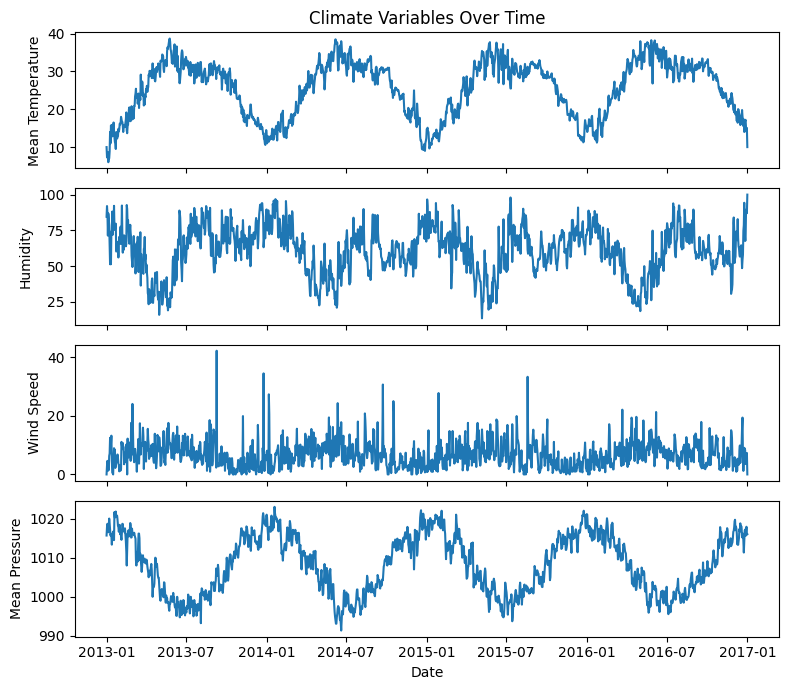

In [ ]:
# Plot das séries univariadas

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 7), sharex=True)

axes[0].plot(train_ds2['date'], train_ds2['meantemp'])
axes[0].set_ylabel('Mean Temperature')
axes[0].set_title('Climate Variables Over Time')

axes[1].plot(train_ds2['date'], train_ds2['humidity'])
axes[1].set_ylabel('Humidity')

axes[2].plot(train_ds2['date'], train_ds2['wind_speed'])
axes[2].set_ylabel('Wind Speed')

axes[3].plot(train_ds2['date'], train_ds2['meanpressure'])
axes[3].set_ylabel('Mean Pressure')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

### Análise de tendência

In [ ]:
!pip install pymannkendall

In [ ]:
import pymannkendall as mk
from scipy.stats import kruskal


In [ ]:
result = mk.original_test(train_ds2['meantemp'])
print(result)

Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(8.173825448265504e-06), z=np.float64(4.4605796981314265), Tau=np.float64(0.077865824712006), s=np.float64(83160.0), var_s=np.float64(347564898.6666667), slope=np.float64(0.0017756239208915382), intercept=np.float64(26.417192440074448))


A série meantemp possui crescente tendência fraca

In [ ]:
result = mk.original_test(train_ds2['humidity'])
print(result)


Mann_Kendall_Test(trend='decreasing', h=np.True_, p=np.float64(0.004995992991412734), z=np.float64(-2.8072920157487853), Tau=np.float64(-0.04900603094969901), s=np.float64(-52338.0), var_s=np.float64(347570148.0), slope=np.float64(-0.0030007060484819924), intercept=np.float64(64.8170157684161))


A série humidity possui tendencia decrescente fraca

In [ ]:
result = mk.original_test(train_ds2['wind_speed'])
print(result)

Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.44238538417937256), z=np.float64(-0.7681713633726763), Tau=np.float64(-0.0134102253670677), s=np.float64(-14322.0), var_s=np.float64(347560540.0), slope=np.float64(-0.00015298776097912064), intercept=np.float64(6.278424226061914))


A série wind_speed não possui tendência

In [ ]:
result = mk.original_test(train_ds2['meanpressure'])
print(result)

Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.5617344878427528), z=np.float64(0.5802671331949), Tau=np.float64(0.010130235179884475), s=np.float64(10819.0), var_s=np.float64(347566579.0), slope=np.float64(0.0002602133749674142), intercept=np.float64(1008.3734061930784))


a série mean_pressure não possui tendência

### Análise de sazonalidade

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram


#### Meantemp

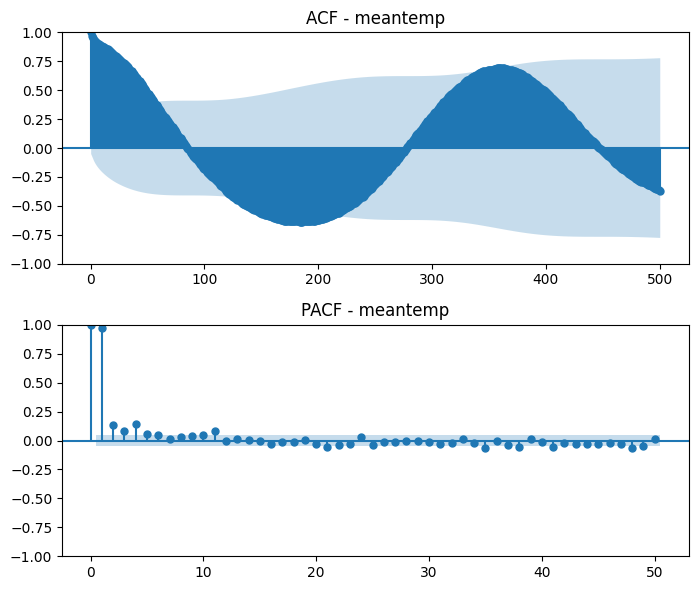

In [ ]:

serie = train_ds2['meantemp'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(7, 6))

# ACF
plot_acf(serie, lags=500, ax=axes[0])
axes[0].set_title("ACF - meantemp")

# PACF
plot_pacf(serie, lags=50, ax=axes[1], method='ywm')
axes[1].set_title("PACF - meantemp")

plt.tight_layout()
plt.show()



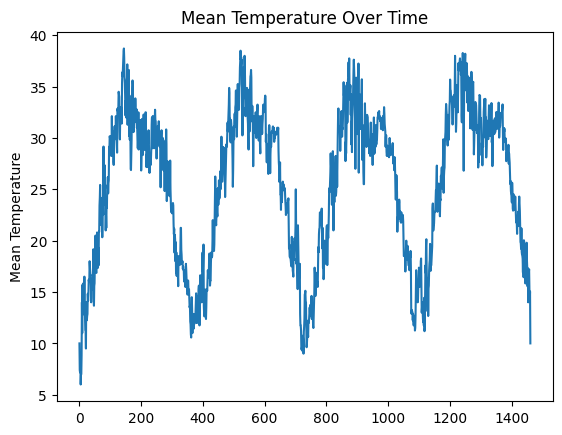

In [ ]:
plt.plot(train_ds2['meantemp'])
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Over Time')
plt.show()

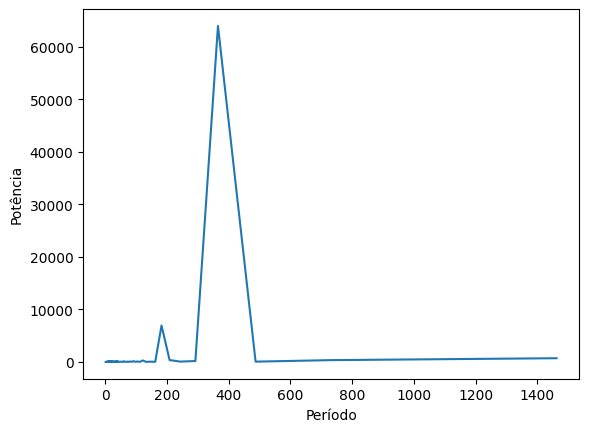

In [ ]:

series = train_ds2['meantemp'].dropna().values
freqs, power = periodogram(series)

# evita frequência zero
freqs = freqs[1:]
power = power[1:]

dominant_freq = freqs[np.argmax(power)]
period = 1 / dominant_freq

plt.plot(1/freqs, power)
plt.xlabel("Período")
plt.ylabel("Potência")
plt.show()


In [ ]:
min_period = 60
mask = (1 / freqs) >= min_period

freqs_f = freqs[mask]
power_f = power[mask]


In [ ]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(power_f,
                      height=np.percentile(power_f, 95),
                      distance=10)

peak_periods = 1 / freqs_f[peaks]
peak_powers = power_f[peaks]

idx = np.argsort(peak_powers)[::-1]

for p, pow_ in zip(peak_periods[idx][:5], peak_powers[idx][:5]):
    print(f"Período ≈ {p:.1f} | Potência = {pow_:.2f}")


Período ≈ 365.5 | Potência = 63982.88


A série possue período de 365.5 anos

#### Humidity

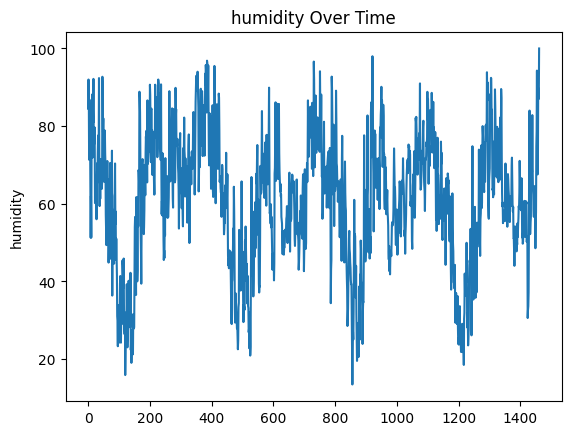

In [ ]:
plt.plot(train_ds2['humidity'])
plt.ylabel('humidity')
plt.title('humidity Over Time')
plt.show()

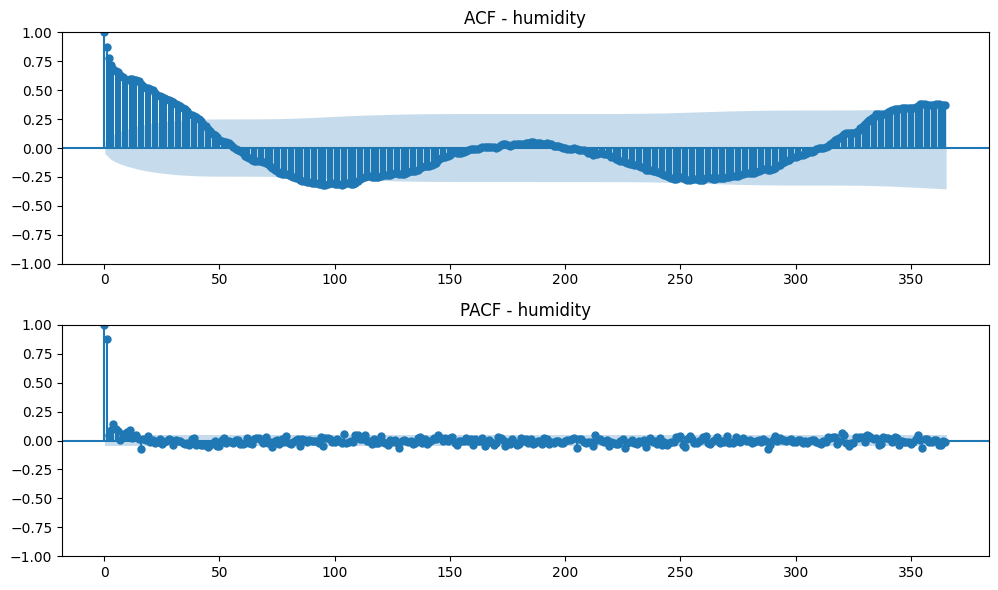

In [ ]:

serie = train_ds2['humidity'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# ACF
plot_acf(serie, lags=365, ax=axes[0])
axes[0].set_title("ACF - humidity")

# PACF
plot_pacf(serie, lags=365, ax=axes[1], method='ywm')  # método mais estável
axes[1].set_title("PACF - humidity")

plt.tight_layout()
plt.show()



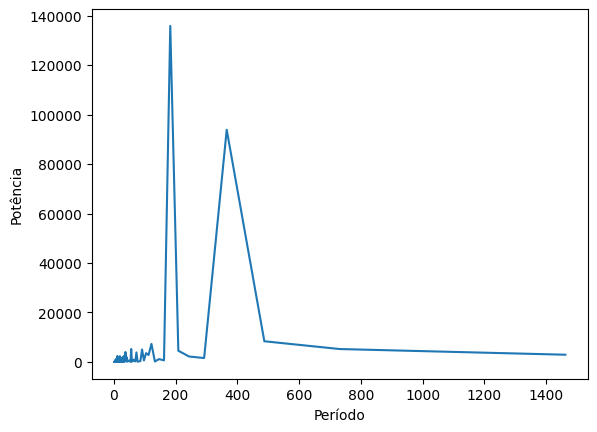

In [ ]:

series = train_ds2['humidity'].dropna().values
freqs, power = periodogram(series)

# evita frequência zero
freqs = freqs[1:]
power = power[1:]

dominant_freq = freqs[np.argmax(power)]
period = 1 / dominant_freq

plt.plot(1/freqs, power)
plt.xlabel("Período")
plt.ylabel("Potência")
plt.show()


In [ ]:
min_period = 60
mask = (1 / freqs) >= min_period

freqs_f = freqs[mask]
power_f = power[mask]


In [ ]:
from scipy.signal import find_peaks
import numpy as np

peaks, _ = find_peaks(power_f,
                      height=np.percentile(power_f, 95), # Filtra picos que estão acima do percentil 95
                      distance=1)

# Calcula o período (1/frequência)
peak_periods = 1 / freqs_f[peaks]
peak_powers = power_f[peaks]

# Ordena os índices em ordem decrescente de potência
idx = np.argsort(peak_powers)[::-1]

print("--- 2 Maiores Picos de Potência ---")

# Itera APENAS sobre os 2 primeiros índices ordenados [idx[:2]]
for p, pow_ in zip(peak_periods[idx][:2], peak_powers[idx][:2]):
    print(f"Período ≈ {p:.1f} | Potência = {pow_:.2f}")

print("-----------------------------------")

--- 2 Maiores Picos de Potência ---
Período ≈ 182.8 | Potência = 135829.91
Período ≈ 365.5 | Potência = 93869.14
-----------------------------------


A série humidity possue dois períodos sazonais dominantes: um ciclo de meio ano e um ciclo anual;

#### wind_speed



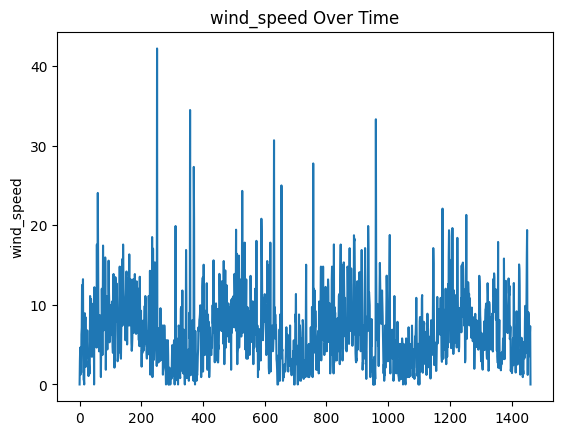

In [ ]:
plt.plot(train_ds2['wind_speed'])
plt.ylabel('wind_speed')
plt.title('wind_speed Over Time')
plt.show()

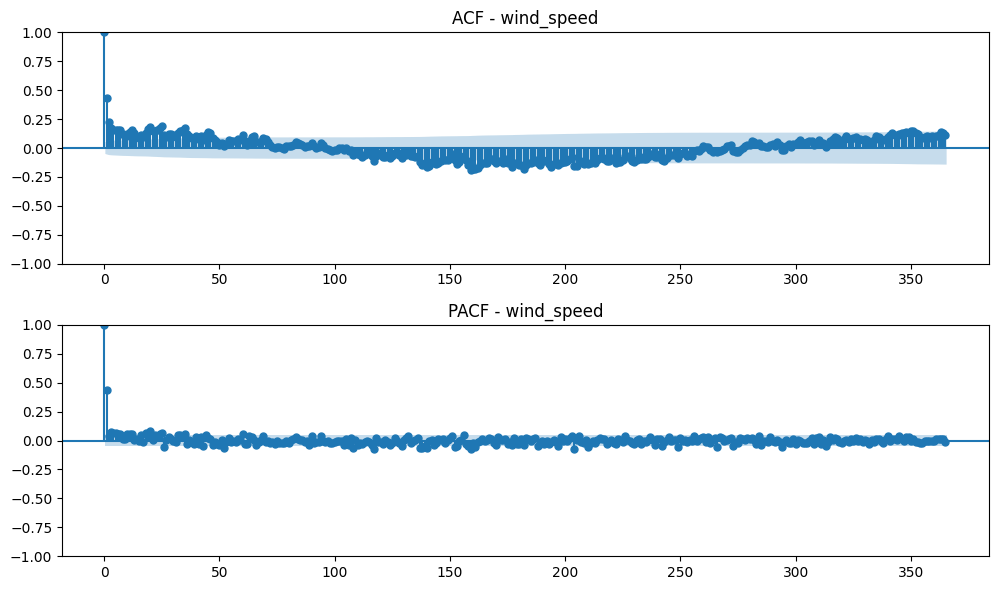

In [ ]:

serie = train_ds2['wind_speed'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# ACF
plot_acf(serie, lags=365, ax=axes[0])
axes[0].set_title("ACF - wind_speed")

# PACF
plot_pacf(serie, lags=365, ax=axes[1], method='ywm')  # método mais estável
axes[1].set_title("PACF - wind_speed")

plt.tight_layout()
plt.show()



acf mostra que há um comportamento sazonal

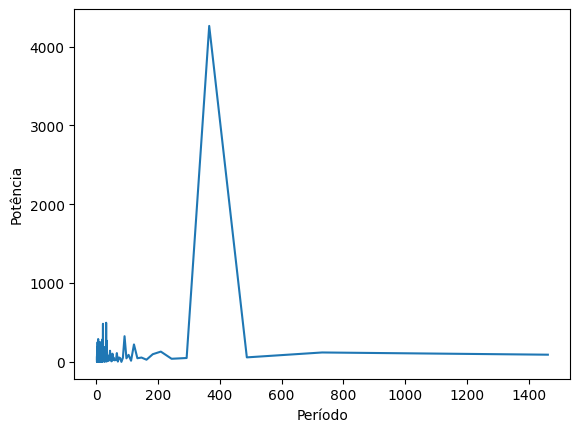

In [ ]:

series = train_ds2['wind_speed'].dropna().values
freqs, power = periodogram(series)

# evita frequência zero
freqs = freqs[1:]
power = power[1:]

dominant_freq = freqs[np.argmax(power)]
period = 1 / dominant_freq

plt.plot(1/freqs, power)
plt.xlabel("Período")
plt.ylabel("Potência")
plt.show()


In [ ]:
min_period = 60
mask = (1 / freqs) >= min_period

freqs_f = freqs[mask]
power_f = power[mask]


In [ ]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(power_f,
                      height=np.percentile(power_f, 95),
                      distance=10)

peak_periods = 1 / freqs_f[peaks]
peak_powers = power_f[peaks]

idx = np.argsort(peak_powers)[::-1]

for p, pow_ in zip(peak_periods[idx][:5], peak_powers[idx][:5]):
    print(f"Período ≈ {p:.1f} | Potência = {pow_:.2f}")


Período ≈ 365.5 | Potência = 4261.15
Período ≈ 91.4 | Potência = 326.14


período anual

#### meanpressure

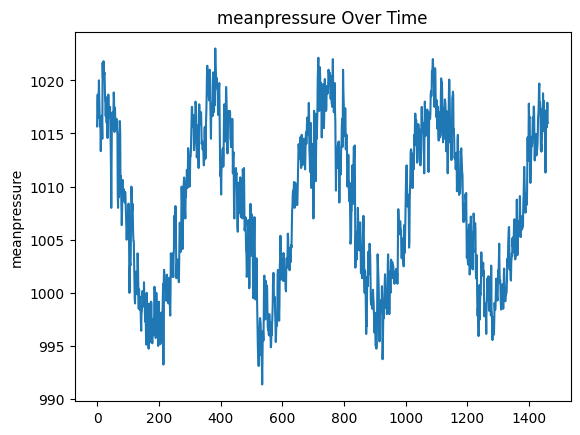

In [ ]:
plt.plot(train_ds2['meanpressure'])
plt.ylabel('meanpressure')
plt.title('meanpressure Over Time')
plt.show()

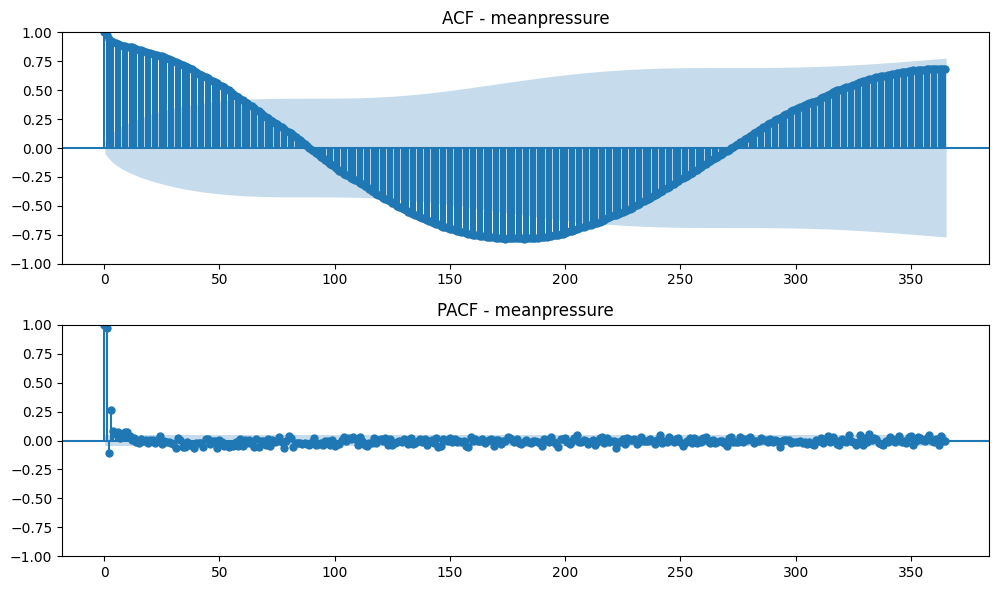

In [ ]:

serie = train_ds2['meanpressure'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# ACF
plot_acf(serie, lags=365, ax=axes[0])
axes[0].set_title("ACF - meanpressure")

# PACF
plot_pacf(serie, lags=365, ax=axes[1], method='ywm')  # método mais estável
axes[1].set_title("PACF - meanpressure")

plt.tight_layout()
plt.show()



acf mostra que há um comportamento sazonal

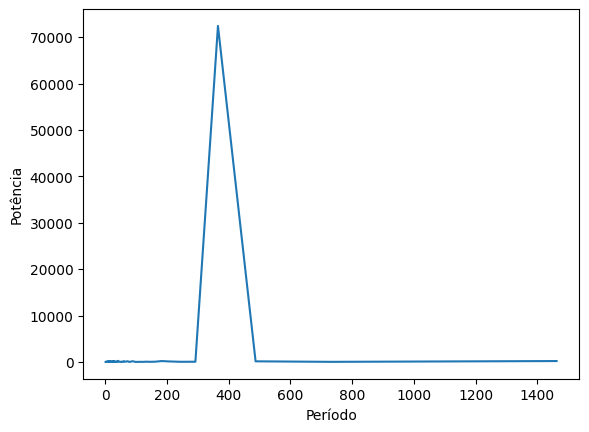

In [ ]:

series = train_ds2['meanpressure'].dropna().values
freqs, power = periodogram(series)

# evita frequência zero
freqs = freqs[1:]
power = power[1:]

dominant_freq = freqs[np.argmax(power)]
period = 1 / dominant_freq

plt.plot(1/freqs, power)
plt.xlabel("Período")
plt.ylabel("Potência")
plt.show()


In [ ]:
from scipy.signal import find_peaks

min_period = 60
mask = (1 / freqs) >= min_period

freqs_f = freqs[mask]
power_f = power[mask]

peaks, _ = find_peaks(power_f,
                      height=np.percentile(power_f, 95),
                      distance=10)

peak_periods = 1 / freqs_f[peaks]
peak_powers = power_f[peaks]

idx = np.argsort(peak_powers)[::-1]

for p, pow_ in zip(peak_periods[idx][:5], peak_powers[idx][:5]):
    print(f"Período ≈ {p:.1f} | Potência = {pow_:.2f}")


Período ≈ 365.5 | Potência = 72412.00


### Estatísticas e Histogramas

In [ ]:
# Calculate descriptive statistics for the series
train_ds_numeric = train_ds2.drop('date', axis=1)
mean_stats = train_ds_numeric.mean()
std_dev_stats = train_ds_numeric.std()
skewness_stats = train_ds_numeric.skew()
kurtosis_stats = train_ds_numeric.kurtosis()

print("Mean of original series:")
print(mean_stats)

print("\nStandard Deviation of original series:")
print(std_dev_stats)

print("\nSkewness of original series:")
print(skewness_stats)

print("\nKurtosis of original series:")
print(kurtosis_stats)

Mean of original series:
meantemp          25.499380
humidity          60.751909
wind_speed         6.793239
meanpressure    1008.248009
dtype: float64

Standard Deviation of original series:
meantemp         7.350568
humidity        16.768356
wind_speed       4.557540
meanpressure     7.439722
dtype: float64

Skewness of original series:
meantemp       -0.446187
humidity       -0.343858
wind_speed      1.442301
meanpressure   -0.062831
dtype: float64

Kurtosis of original series:
meantemp       -0.937749
humidity       -0.310290
wind_speed      5.077359
meanpressure   -1.252409
dtype: float64


a distribuição dos valores assumidos pela série são quase simétricas, com exceção de wind_speed, que possui forte assimetria positiva;

wind_speed possui alta curtose, ou seja, possui picos mais altos (maior concentração de dados em torno da média) e caudas mais pesadas (os valores extremos são mais frequentes); isso explica o número de dados discrepantes encontrados na análise de outliers;

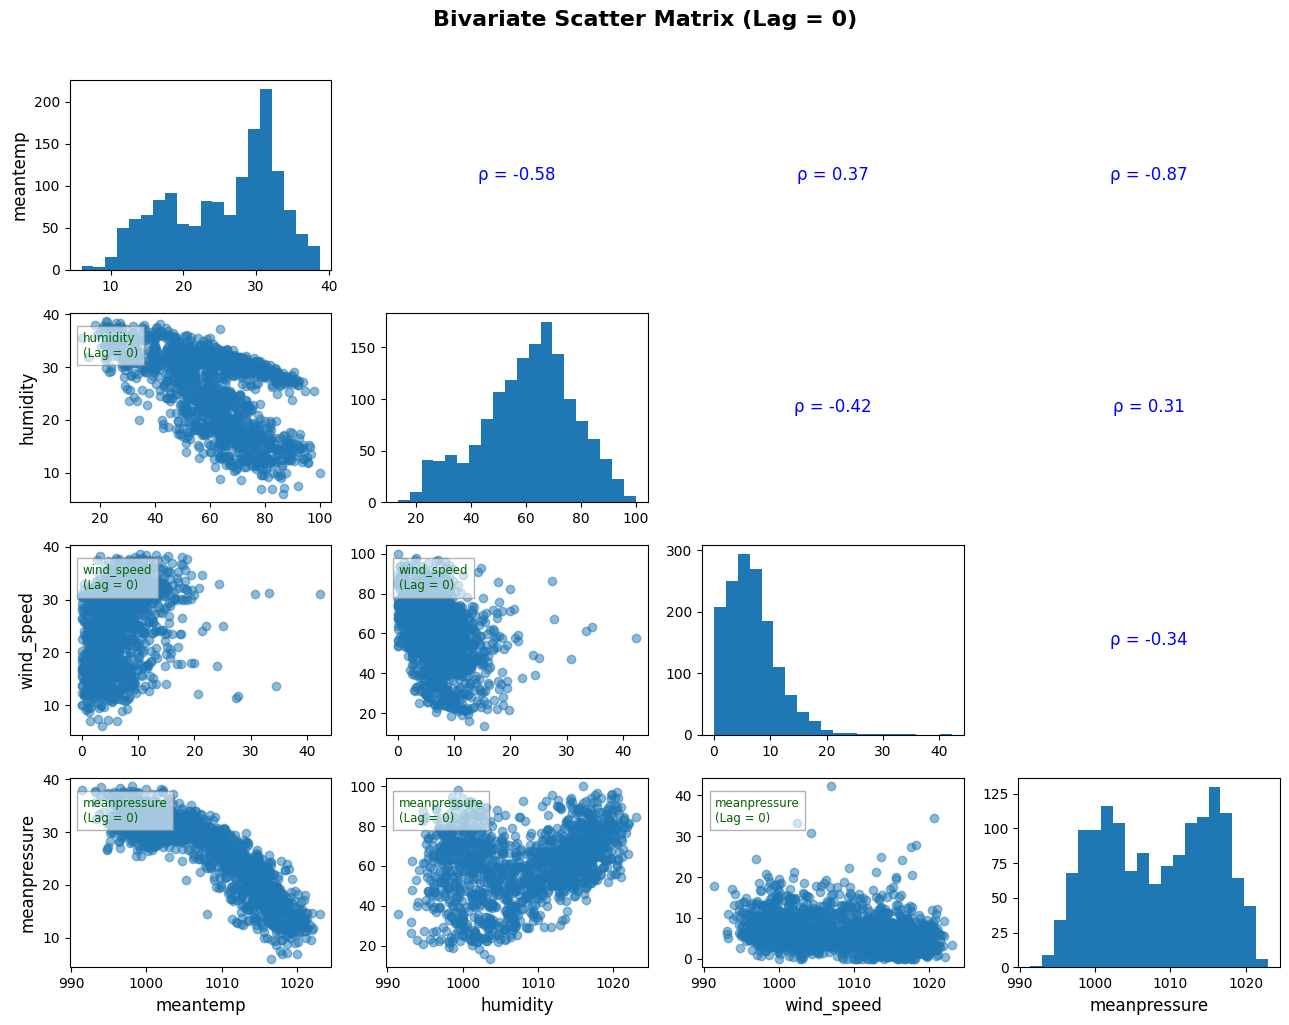

In [ ]:
plot_bivariate_scatter(train_ds2.drop('date', axis=1), lag=0, size=(13,10))

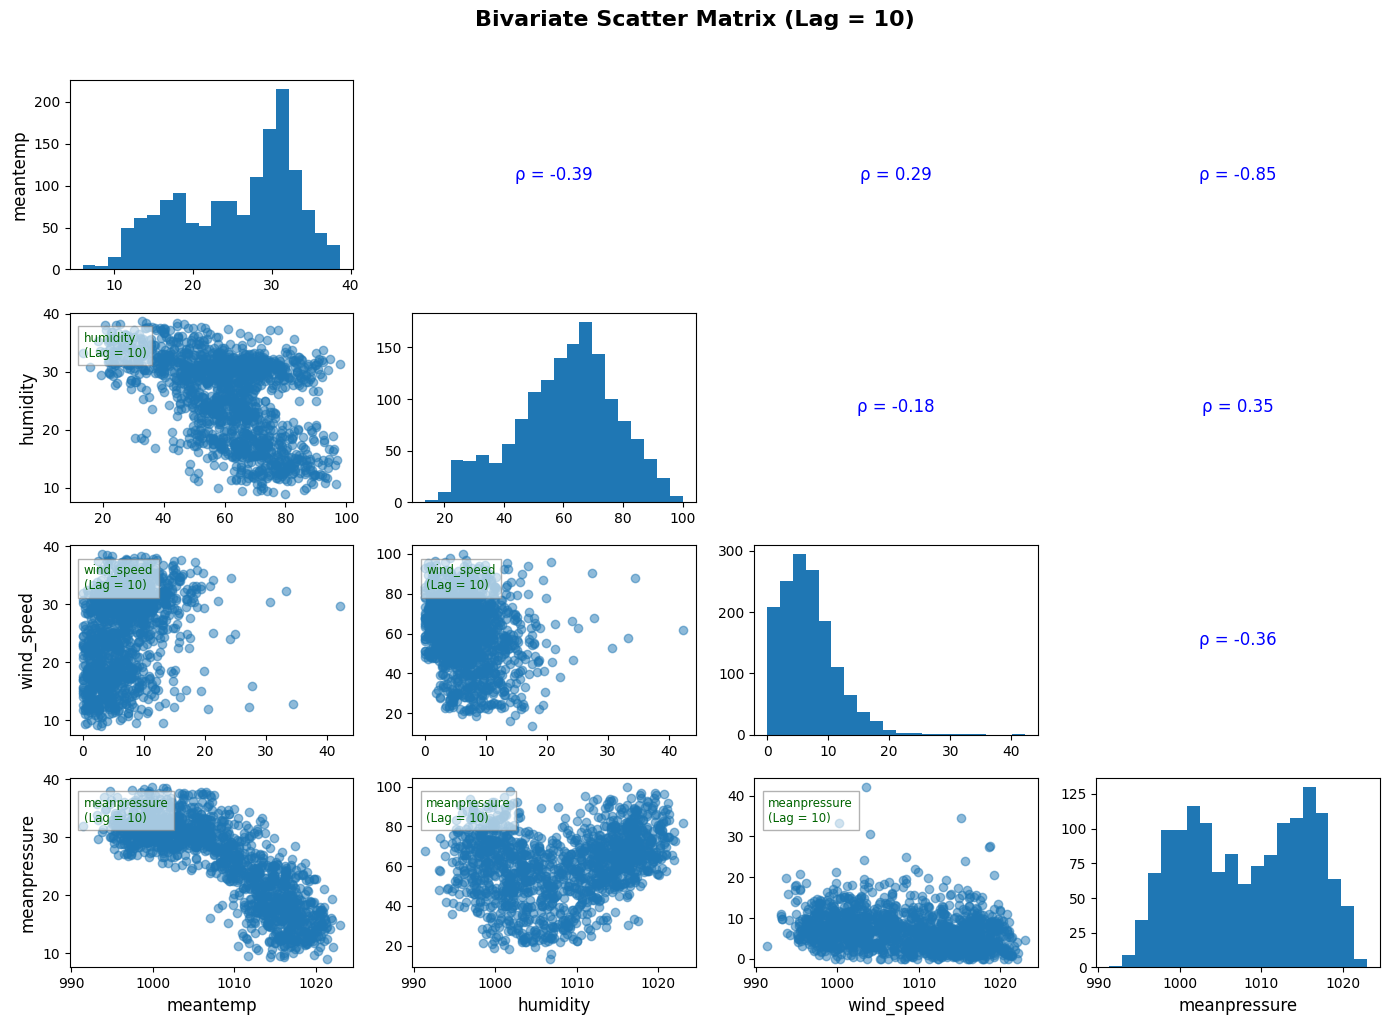

In [ ]:
plot_bivariate_scatter(train_ds2.drop('date', axis=1), lag=10, size=(14,10))

É possível observar que as variáveis mean pressure e meantemp possui uma alta correlação negativa, inclusive quando há defasagens no lag; logo, pode-se usar meanpressure para ajudar na previsão de meantemp;

A correlaçao entre as outras não é significativa;

### Analisando humidity x meantemp

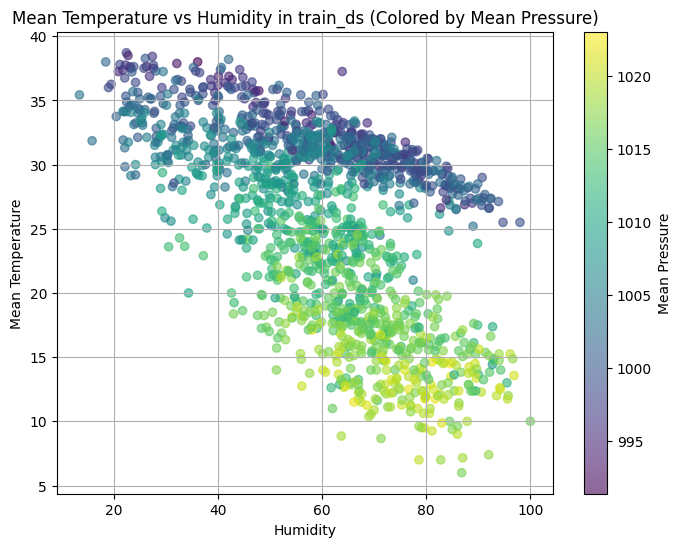

In [ ]:
plt.figure(figsize=(8, 6))

# Create a scatter plot with color mapping based on 'meanpressure'
scatter = plt.scatter(train_ds2['humidity'], train_ds2['meantemp'], c=train_ds2['meanpressure'], cmap='viridis', alpha=0.6)

plt.xlabel('Humidity')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature vs Humidity in train_ds (Colored by Mean Pressure)')
plt.colorbar(scatter, label='Mean Pressure') # Add a color bar to show the mapping
plt.grid(True)
plt.show()

como dito anteriormente, é possível observar duas nuvens de pontos distintas

Threshold T for meanpressure: 1007.5714


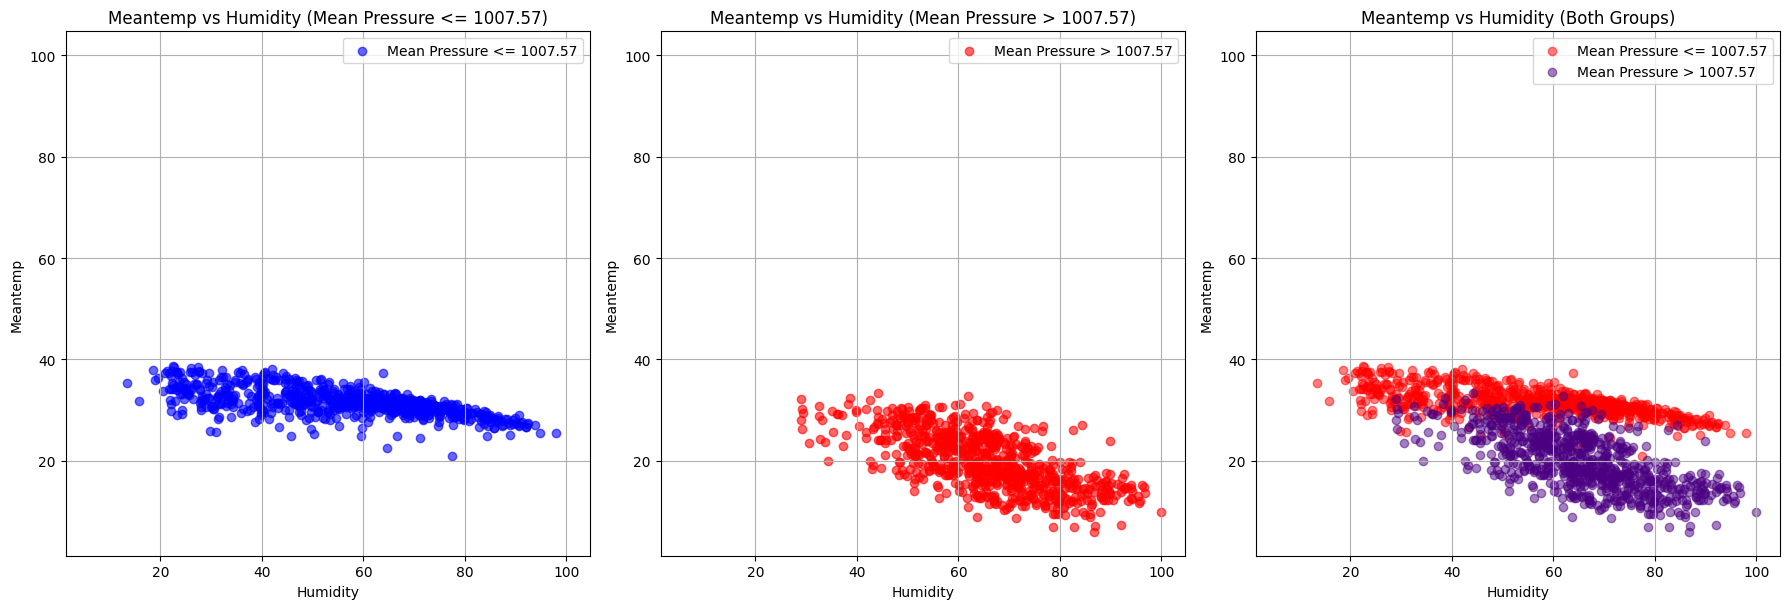

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the threshold T as the median of meanpressure in train_ds2
T = train_ds2['meanpressure'].median()
T = 1007.5714
print(f"Threshold T for meanpressure: {T:.4f}")

# Create a boolean mask based on the threshold
pressure_condition = train_ds2['meanpressure'] <= T

# Define the two groups based on the pressure condition
group_low_pressure = train_ds2[pressure_condition]
group_high_pressure = train_ds2[~pressure_condition]

# Choose the variables for the scatter plot
x_variable = 'humidity'
y_variable = 'meantemp'

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6)) # Adjusted figure size for three side-by-side plots

# Plot for Mean Pressure <= T
axes[0].scatter(group_low_pressure[x_variable], group_low_pressure[y_variable], color='blue', alpha=0.6, label=f'Mean Pressure <= {T:.2f}')
axes[0].set_xlabel(x_variable.capitalize())
axes[0].set_ylabel(y_variable.capitalize())
axes[0].set_title(f'{y_variable.capitalize()} vs {x_variable.capitalize()} (Mean Pressure <= {T:.2f})')
axes[0].grid(True)
axes[0].legend()


# Plot for Mean Pressure > T
axes[1].scatter(group_high_pressure[x_variable], group_high_pressure[y_variable], color='red', alpha=0.6, label=f'Mean Pressure > {T:.2f}')
axes[1].set_xlabel(x_variable.capitalize())
axes[1].set_ylabel(y_variable.capitalize())
axes[1].set_title(f'{y_variable.capitalize()} vs {x_variable.capitalize()} (Mean Pressure > {T:.2f})')
axes[1].grid(True)
axes[1].legend()


# Plot both groups together
axes[2].scatter(group_low_pressure[x_variable], group_low_pressure[y_variable], color='red', alpha=0.5, label=f'Mean Pressure <= {T:.2f}')
axes[2].scatter(group_high_pressure[x_variable], group_high_pressure[y_variable], color='indigo', alpha=0.5, label=f'Mean Pressure > {T:.2f}')
axes[2].set_xlabel(x_variable.capitalize())
axes[2].set_ylabel(y_variable.capitalize())
axes[2].set_title(f'{y_variable.capitalize()} vs {x_variable.capitalize()} (Both Groups)')
axes[2].legend()
axes[2].grid(True)


# Optional: Set equal limits for all subplots for better comparison
all_data_x = train_ds2[x_variable]
all_data_y = train_ds2[y_variable]
max_limit = max(all_data_x.max(), all_data_y.max())
min_limit = min(all_data_x.min(), all_data_y.min())

buffer = (max_limit - min_limit) * 0.05
for ax in axes:
    ax.set_xlim(min_limit - buffer, max_limit + buffer)
    ax.set_ylim(min_limit - buffer, max_limit + buffer)
    ax.set_aspect('equal', adjustable='box') # Ensure aspect ratio is equal


plt.tight_layout()
plt.show()

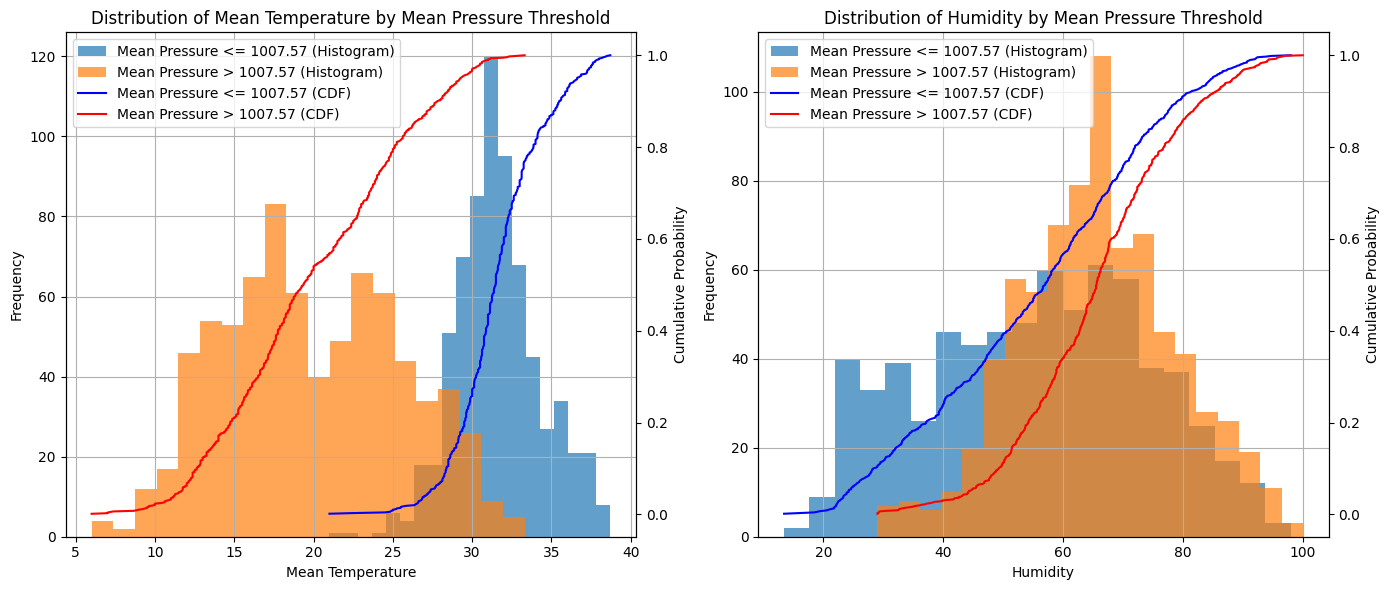

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming T and pressure_condition are already defined from previous cells
# Define the two groups based on the pressure condition
group_low_pressure = train_ds2[pressure_condition]
group_high_pressure = train_ds2[~pressure_condition]

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6)) # Adjusted figure size for side-by-side plots

# Plot overlaid histograms for 'meantemp' on the first subplot
axes[0].hist(group_low_pressure['meantemp'].dropna(), bins=20, alpha=0.7, label=f'Mean Pressure <= {T:.2f} (Histogram)')
axes[0].hist(group_high_pressure['meantemp'].dropna(), bins=20, alpha=0.7, label=f'Mean Pressure > {T:.2f} (Histogram)')
axes[0].set_xlabel('Mean Temperature')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Mean Temperature by Mean Pressure Threshold')
axes[0].grid(True)

# Add a secondary y-axis for the CDF
ax2_meantemp = axes[0].twinx()
# Calculate and plot the CDF for the low pressure group
sorted_meantemp_low = np.sort(group_low_pressure['meantemp'].dropna())
cdf_low_meantemp = np.arange(1, len(sorted_meantemp_low) + 1) / len(sorted_meantemp_low)
ax2_meantemp.plot(sorted_meantemp_low, cdf_low_meantemp, color='blue', linestyle='-', label=f'Mean Pressure <= {T:.2f} (CDF)')

# Calculate and plot the CDF for the high pressure group
sorted_meantemp_high = np.sort(group_high_pressure['meantemp'].dropna())
cdf_high_meantemp = np.arange(1, len(sorted_meantemp_high) + 1) / len(sorted_meantemp_high)
ax2_meantemp.plot(sorted_meantemp_high, cdf_high_meantemp, color='red', linestyle='-', label=f'Mean Pressure > {T:.2f} (CDF)')

ax2_meantemp.set_ylabel('Cumulative Probability')
# Combine legends from both axes
lines, labels = axes[0].get_legend_handles_labels()
lines2, labels2 = ax2_meantemp.get_legend_handles_labels()
ax2_meantemp.legend(lines + lines2, labels + labels2, loc='best')


# Plot overlaid histograms for 'humidity' on the second subplot
axes[1].hist(group_low_pressure['humidity'].dropna(), bins=20, alpha=0.7, label=f'Mean Pressure <= {T:.2f} (Histogram)')
axes[1].hist(group_high_pressure['humidity'].dropna(), bins=20, alpha=0.7, label=f'Mean Pressure > {T:.2f} (Histogram)')
axes[1].set_xlabel('Humidity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Humidity by Mean Pressure Threshold')
axes[1].grid(True)

# Add a secondary y-axis for the CDF
ax2_humidity = axes[1].twinx()
# Calculate and plot the CDF for the low pressure group
sorted_humidity_low = np.sort(group_low_pressure['humidity'].dropna())
cdf_low_humidity = np.arange(1, len(sorted_humidity_low) + 1) / len(sorted_humidity_low)
ax2_humidity.plot(sorted_humidity_low, cdf_low_humidity, color='blue', linestyle='-', label=f'Mean Pressure <= {T:.2f} (CDF)')

# Calculate and plot the CDF for the high pressure group
sorted_humidity_high = np.sort(group_high_pressure['humidity'].dropna())
cdf_high_humidity = np.arange(1, len(sorted_humidity_high) + 1) / len(sorted_humidity_high)
ax2_humidity.plot(sorted_humidity_high, cdf_high_humidity, color='red', linestyle='-', label=f'Mean Pressure > {T:.2f} (CDF)')

ax2_humidity.set_ylabel('Cumulative Probability')
# Combine legends from both axes
lines, labels = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2_humidity.get_legend_handles_labels()
ax2_humidity.legend(lines + lines2, labels + labels2, loc='best')


plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import levene, bartlett
from statsmodels.api import OLS, add_constant

# --- Levene e Bartlett: igualdade de variâncias nos resíduos ---
print("=== Testes de Igualdade de Variâncias ===")

# Define X_low, y_low, X_high, and y_high
X_low = group_low_pressure['humidity'].values.reshape(-1, 1)
y_low = group_low_pressure['meantemp'].values
X_high = group_high_pressure['humidity'].values.reshape(-1, 1)
y_high = group_high_pressure['meantemp'].values

# Use os resíduos de cada grupo (já calculados anteriormente)
# Recalculate residuals based on the defined X and y
reg_low = OLS(y_low, add_constant(X_low)).fit()
reg_high = OLS(y_high, add_constant(X_high)).fit()

resid_low = reg_low.resid
resid_high = reg_high.resid


# Teste de Levene (menos sensível à não normalidade)
stat_levene, p_levene = levene(resid_low, resid_high, center='median')
print(f"Levene Test:  stat = {stat_levene:.4f},  p-value = {p_levene:.4f}")

# Teste de Bartlett (assume normalidade)
stat_bartlett, p_bartlett = bartlett(resid_low, resid_high)
print(f"Bartlett Test: stat = {stat_bartlett:.4f},  p-value = {p_bartlett:.4f}")

print("\n=== Teste de Chow: mudança estrutural na regressão ===")

# --- Teste de Chow ---
# Combina os dois conjuntos
combined_X = np.concatenate([X_low, X_high])
combined_y = np.concatenate([y_low, y_high])

# Adiciona constante (intercepto)
combined_X_const = add_constant(combined_X)
X_low_const = add_constant(X_low)
X_high_const = add_constant(X_high)

# Regressões separadas
ols_low = OLS(y_low, X_low_const).fit()
ols_high = OLS(y_high, X_high_const).fit()

# Regressão conjunta
ols_pooled = OLS(combined_y, combined_X_const).fit()

# Soma dos quadrados dos resíduos
SSR_pooled = np.sum(ols_pooled.resid ** 2)
SSR_low = np.sum(ols_low.resid ** 2)
SSR_high = np.sum(ols_high.resid ** 2)

# Graus de liberdade
k = X_low_const.shape[1]  # número de parâmetros (inclui intercepto)
n_low = len(y_low)
n_high = len(y_high)

# Estatística F do teste de Chow
numerator = (SSR_pooled - (SSR_low + SSR_high)) / k
denominator = (SSR_low + SSR_high) / (n_low + n_high - 2 * k)
F_chow = numerator / denominator

from scipy.stats import f
p_chow = 1 - f.cdf(F_chow, k, n_low + n_high - 2 * k)

print(f"Chow Test: F = {F_chow:.4f},  p-value = {p_chow:.4f}")

# Interpretação resumida
print("\n--- Interpretação ---")
if p_levene < 0.05:
    print("→ Levene: rejeita H0, as variâncias dos resíduos são diferentes entre os grupos.")
else:
    print("→ Levene: não rejeita H0, variâncias semelhantes.")

if p_chow < 0.05:
    print("→ Chow: rejeita H0, há diferença significativa entre as regressões (estrutura mudou).")
else:
    print("→ Chow: não rejeita H0, as regressões podem ser consideradas equivalentes.")

=== Testes de Igualdade de Variâncias ===
Levene Test:  stat = 274.9143,  p-value = 0.0000
Bartlett Test: stat = 297.1391,  p-value = 0.0000

=== Teste de Chow: mudança estrutural na regressão ===
Chow Test: F = 1620.8985,  p-value = 0.0000

--- Interpretação ---
→ Levene: rejeita H0, as variâncias dos resíduos são diferentes entre os grupos.
→ Chow: rejeita H0, há diferença significativa entre as regressões (estrutura mudou).


ou seja, podemos considerar que são 2 grupos diferentes com características próprias

## Correlação Cruzada + Seasonal Plot

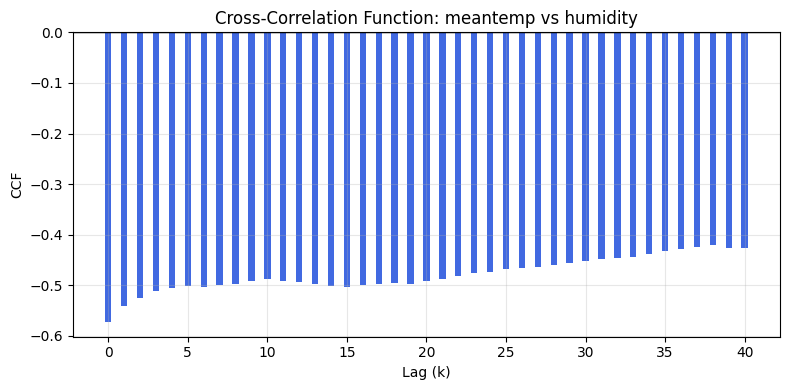

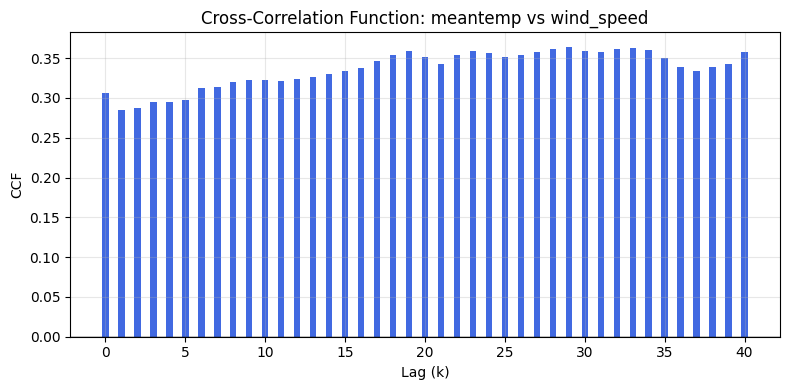

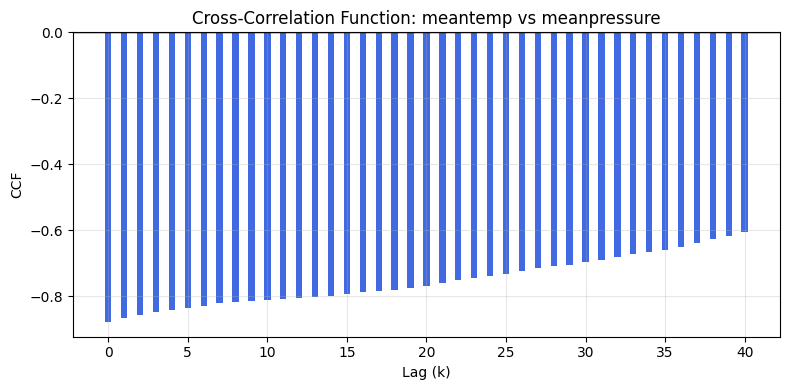

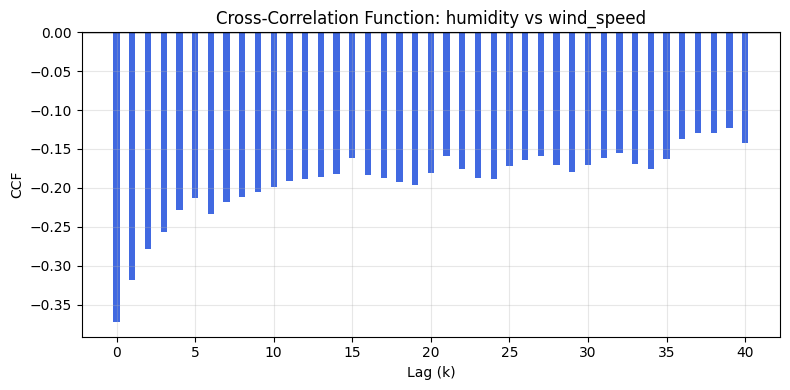

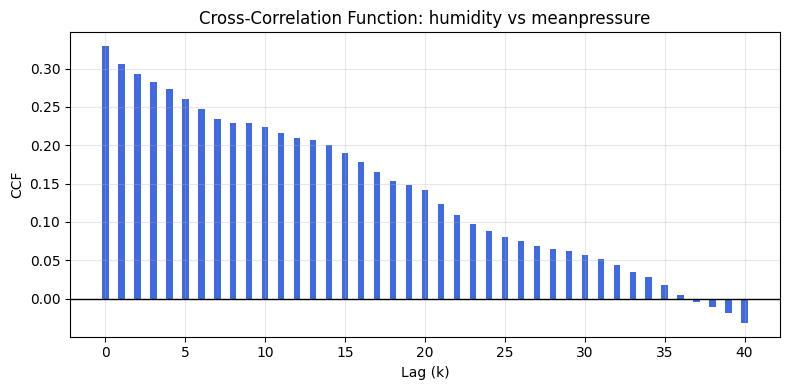

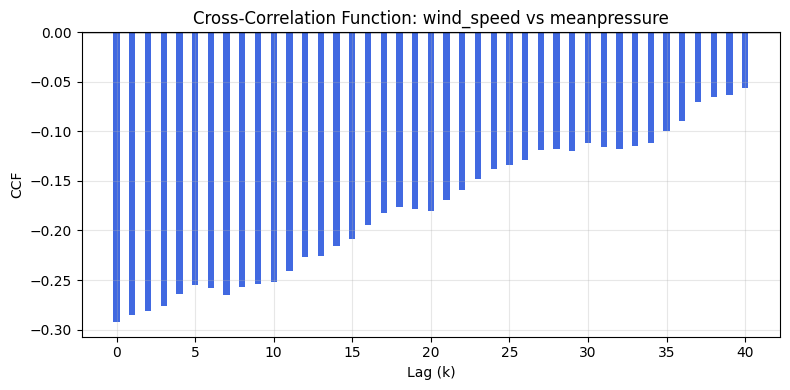

In [ ]:
plot_pairwise_crosscorrelations(train_ds2, max_lag=40)


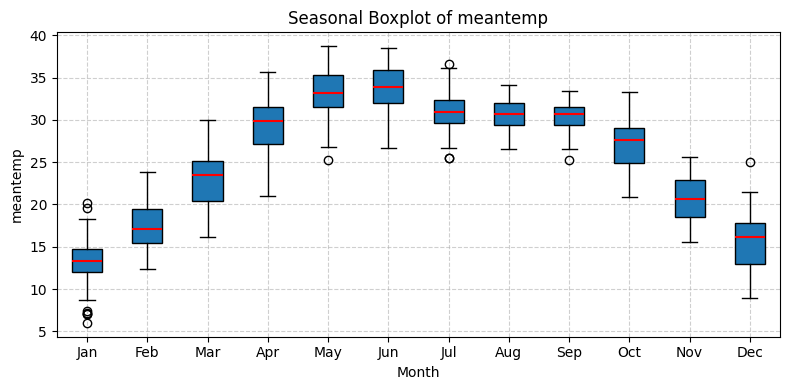

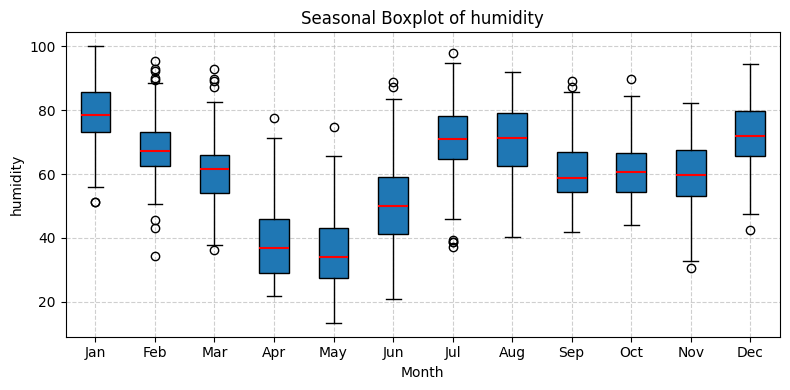

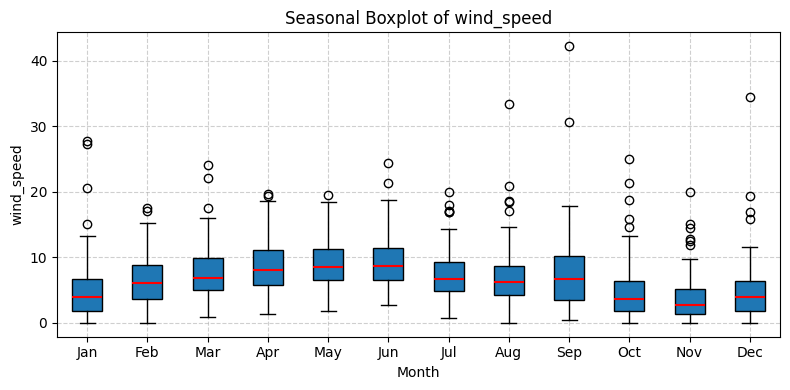

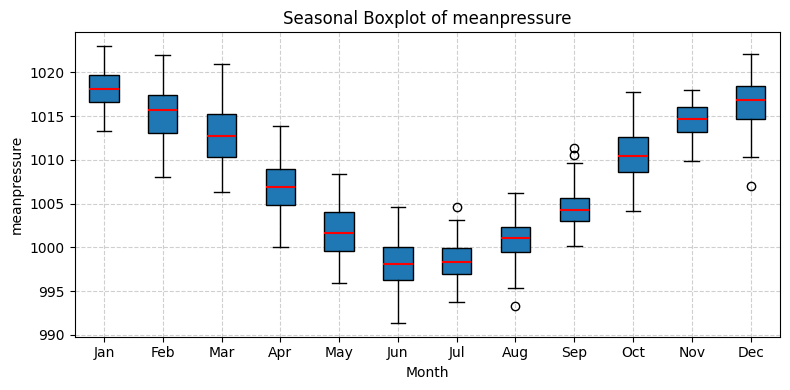

In [ ]:
train_ds2['date'] = pd.to_datetime(train_ds2['date'])

# Extrair ano e mês
train_ds2['year'] = train_ds2['date'].dt.year
train_ds2['month'] = train_ds2['date'].dt.month

# Selecionar colunas numéricas
numerical_cols = train_ds2.select_dtypes(include=np.number).columns.drop(['year', 'month'], errors='ignore')

# Cria boxplots mensais para cada variável numérica
for col in numerical_cols:
    plt.figure(figsize=(8, 4))

    # Agrupar por mês
    grouped = [train_ds2.loc[train_ds2['month'] == m, col].dropna() for m in range(1, 13)]

    # Criar o boxplot
    plt.boxplot(grouped, patch_artist=True,
                boxprops=dict( color='black'),
                medianprops=dict(color='red', linewidth=1.5))

    plt.xlabel('Month')
    plt.ylabel(col)
    plt.title(f'Seasonal Boxplot of {col}')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


train_ds2 = train_ds2.drop(['year', 'month'], axis=1)


meanpressure e meantemp tem um comportamento sazonal bem definido

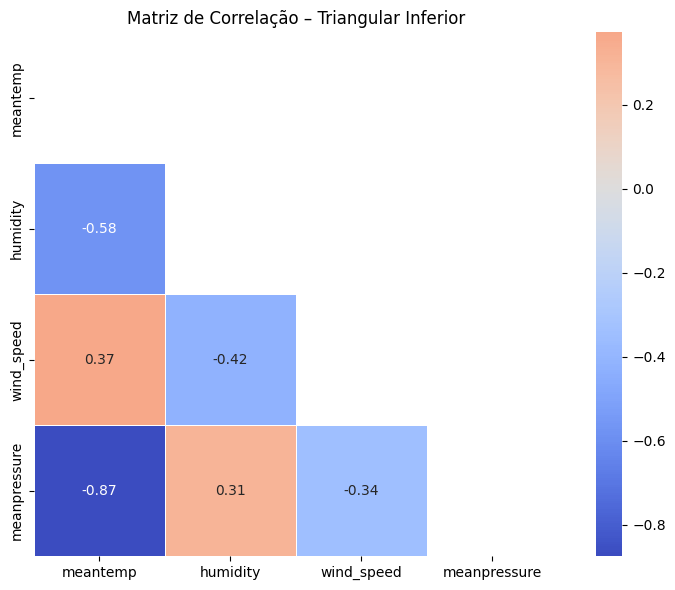

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

numeric_ds = train_ds2.drop(columns=['date'])

corr_matrix = numeric_ds.corr(method='spearman')

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot do heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True
)

plt.title("Matriz de Correlação – Triangular Inferior")
plt.tight_layout()
plt.show()


## Feature Engineering

In [ ]:
train_ds3 = train_ds2.copy()

Variável binária para indicar se a pressão é baixa ou não

In [ ]:
train_ds3["is_low_pressure"] = pressure_condition

In [ ]:
train_ds3["is_low_pressure"].value_counts()

is_low_pressure
False    768
True     694
Name: count, dtype: int64

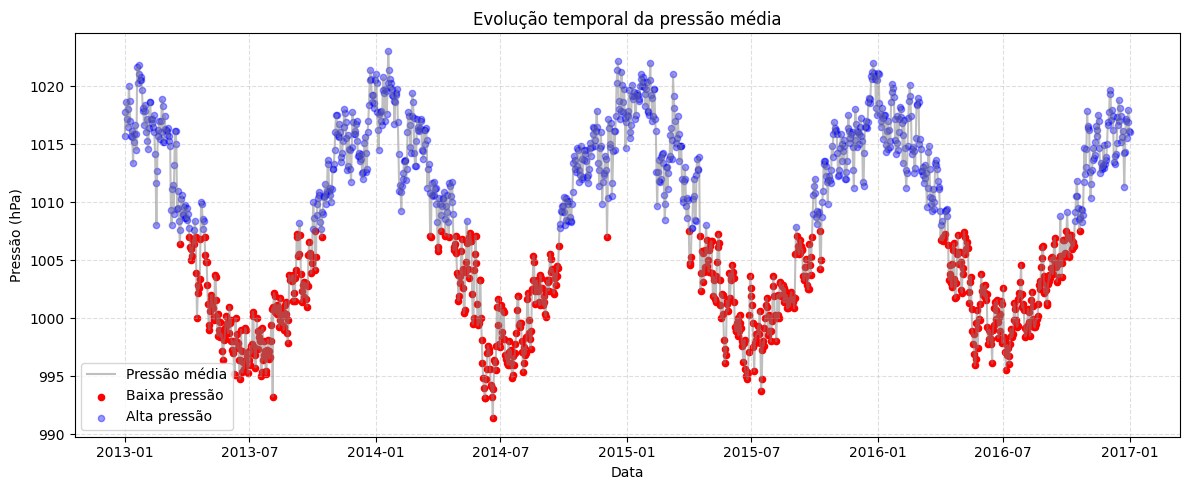

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Série original
plt.plot(train_ds3["date"], train_ds3["meanpressure"], color="gray", alpha=0.5, label="Pressão média")

# Destacar regiões de baixa pressão
plt.scatter(
    train_ds3.loc[train_ds3["is_low_pressure"], "date"],
    train_ds3.loc[train_ds3["is_low_pressure"], "meanpressure"],
    color="red", label="Baixa pressão", s=20
)

# E as de alta pressão (opcional)
plt.scatter(
    train_ds3.loc[~train_ds3["is_low_pressure"], "date"],
    train_ds3.loc[~train_ds3["is_low_pressure"], "meanpressure"],
    color="blue", label="Alta pressão", s=20, alpha=0.4
)

plt.title("Evolução temporal da pressão média")
plt.xlabel("Data")
plt.ylabel("Pressão (hPa)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


funções periódicas para capturar sazonalidade

In [ ]:
train_ds3["dayofyear"] = train_ds3["date"].dt.dayofyear

train_ds3["sin_year"] = np.sin(2 * np.pi * train_ds3["dayofyear"] / 365)
# train_ds3["cos_year"] = np.cos(2 * np.pi * train_ds3["dayofyear"] / 365) #alta correlação com pressure_ma50

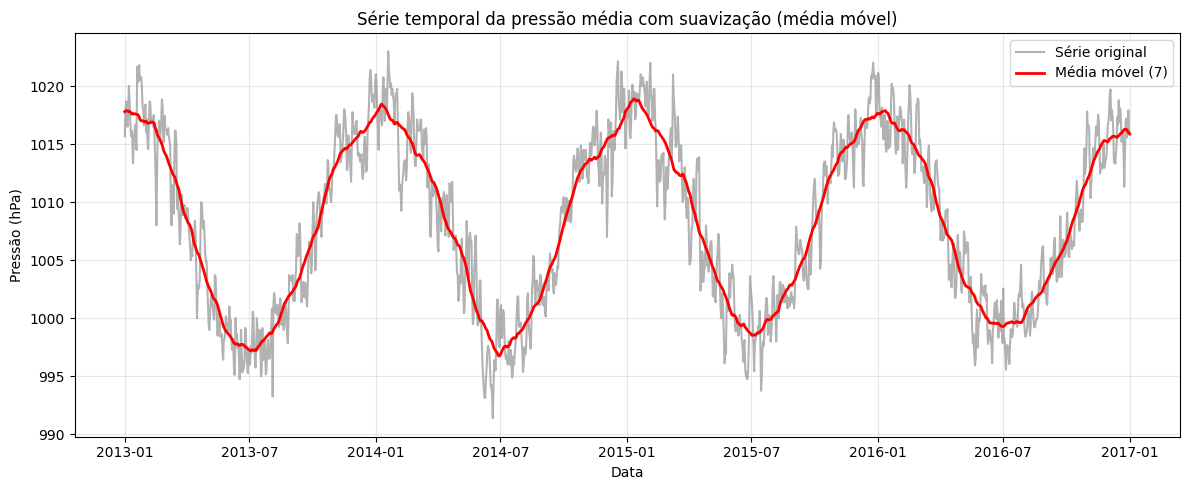

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- calcula a média móvel de 50 dias (pode ajustar a janela) ---
train_ds3["pressure_ma50"] = train_ds3["meanpressure"].rolling(window=50, center=True, min_periods=1).mean()

# --- plota a série original e a média móvel ---
plt.figure(figsize=(12, 5))
plt.plot(train_ds3["date"], train_ds3["meanpressure"], label="Série original", color="gray", alpha=0.6)
plt.plot(train_ds3["date"], train_ds3["pressure_ma50"], label="Média móvel (7)", color="red", linewidth=2)
plt.title("Série temporal da pressão média com suavização (média móvel)")
plt.xlabel("Data")
plt.ylabel("Pressão (hPa)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


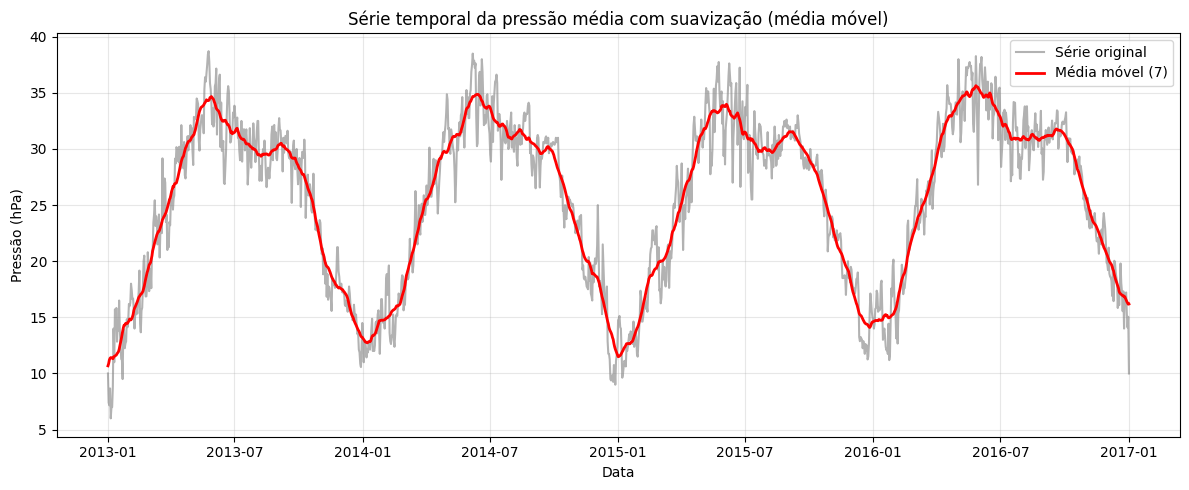

In [ ]:
# --- calcula a média móvel de 7 dias (pode ajustar a janela) ---
train_ds3["temp_ma50"] = train_ds3["meantemp"].rolling(window=30, center=True, min_periods=1).mean()

# --- plota a série original e a média móvel ---
plt.figure(figsize=(12, 5))
plt.plot(train_ds3["date"], train_ds3["meantemp"], label="Série original", color="gray", alpha=0.6)
plt.plot(train_ds3["date"], train_ds3["temp_ma50"], label="Média móvel (7)", color="red", linewidth=2)
plt.title("Série temporal da pressão média com suavização (média móvel)")
plt.xlabel("Data")
plt.ylabel("Pressão (hPa)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
train_ds3

date   meantemp    humidity  wind_speed  meanpressure  \
0    2013-01-01  10.000000   84.500000    0.000000   1015.666667   
1    2013-01-02   7.400000   92.000000    2.980000   1017.800000   
2    2013-01-03   7.166667   87.000000    4.633333   1018.666667   
3    2013-01-04   8.666667   71.333333    1.233333   1017.166667   
4    2013-01-05   6.000000   86.833333    3.700000   1016.500000   
...         ...        ...         ...         ...           ...   
1457 2016-12-28  17.217391   68.043478    3.547826   1015.565217   
1458 2016-12-29  15.238095   87.857143    6.000000   1016.904762   
1459 2016-12-30  14.095238   89.666667    6.266667   1017.904762   
1460 2016-12-31  15.052632   87.000000    7.325000   1016.100000   
1461 2017-01-01  10.000000  100.000000    0.000000   1016.000000   

      is_low_pressure  dayofyear      sin_year  pressure_ma50  temp_ma50  
0               False          1  1.721336e-02    1017.790190  10.679048  
1               False          2  3.442161e-02    1017.862363  10.876190  
2               False          3  5.161967e-02    1017.872751  11.207003  
3               False          4  6.880243e-02    1017.871344  11.352910  
4               False          5  8.596480e-02    1017.828366  11.413283  
...               ...        ...           ...            ...        ...  
1457            False        363 -3.442161e-02    1016.213193  16.532307  
1458            False        364 -1.721336e-02    1016.105602  16.399797  
1459            False        365  6.432491e-16    1015.977231  16.280033  
1460            False        366  1.721336e-02    1015.937667  16.169054  
1461            False          1  1.721336e-02    1015.859826  16.190037  

[1462 rows x 10 columns]

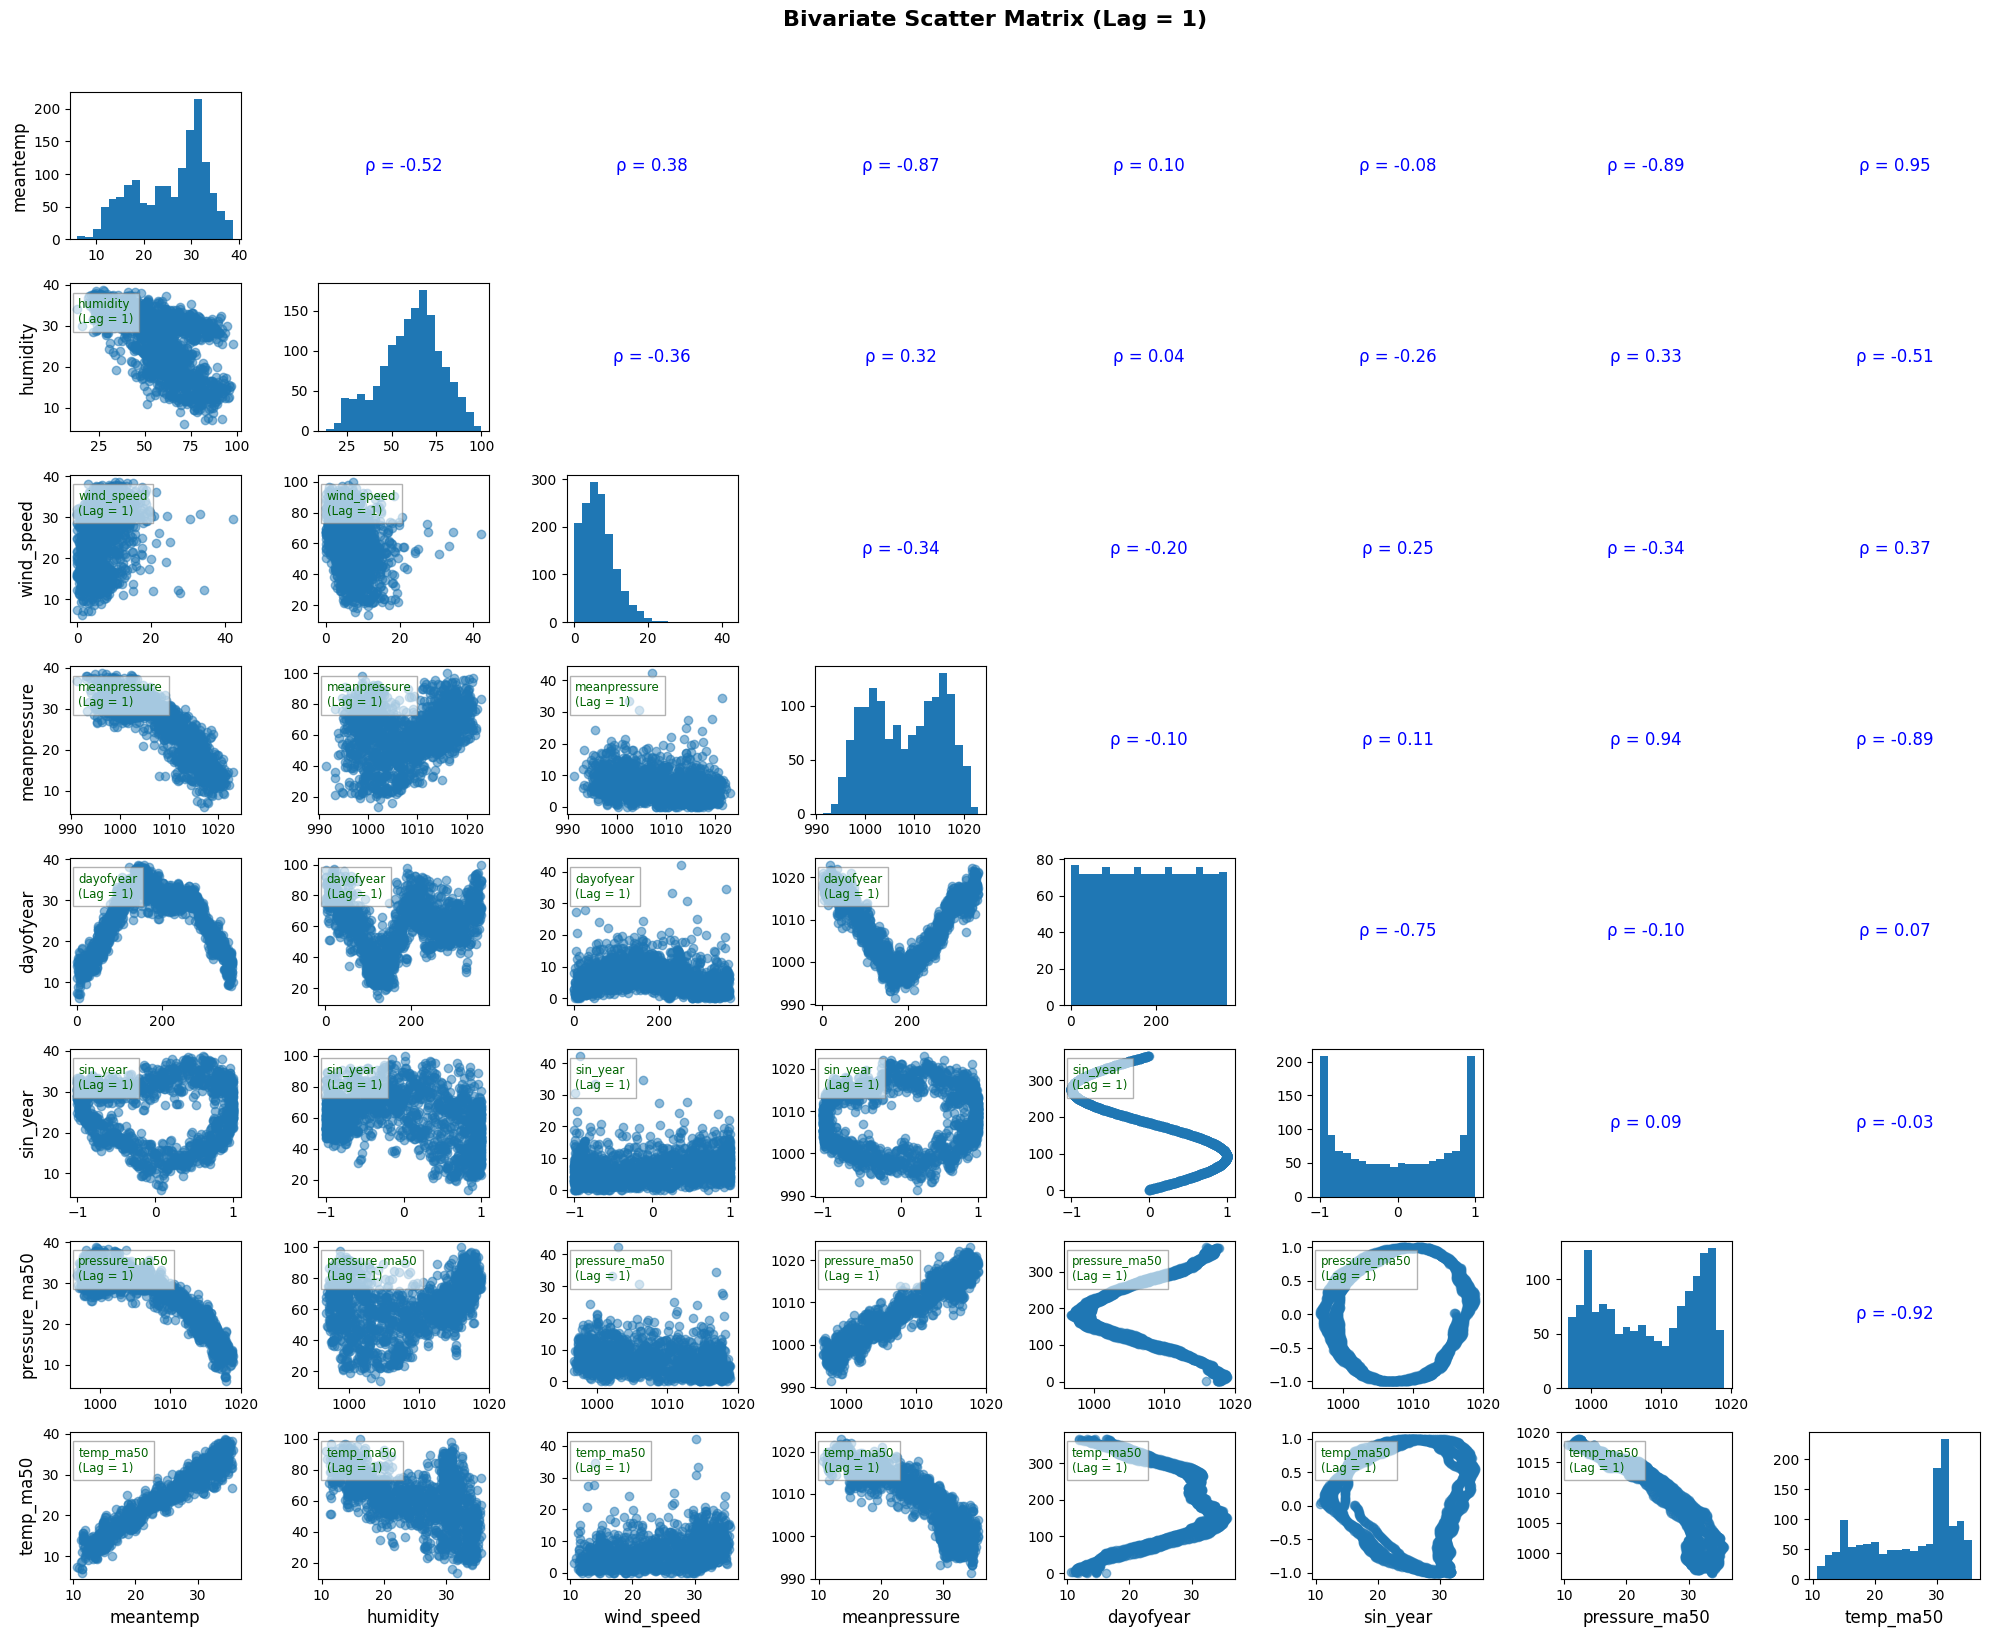

In [ ]:

plot_bivariate_scatter(train_ds3.drop(['date', 'is_low_pressure'], axis=1), lag=1, size=(20,16))

In [ ]:
train_ds3["season_half"] = (train_ds3["dayofyear"] > 180).astype(int)

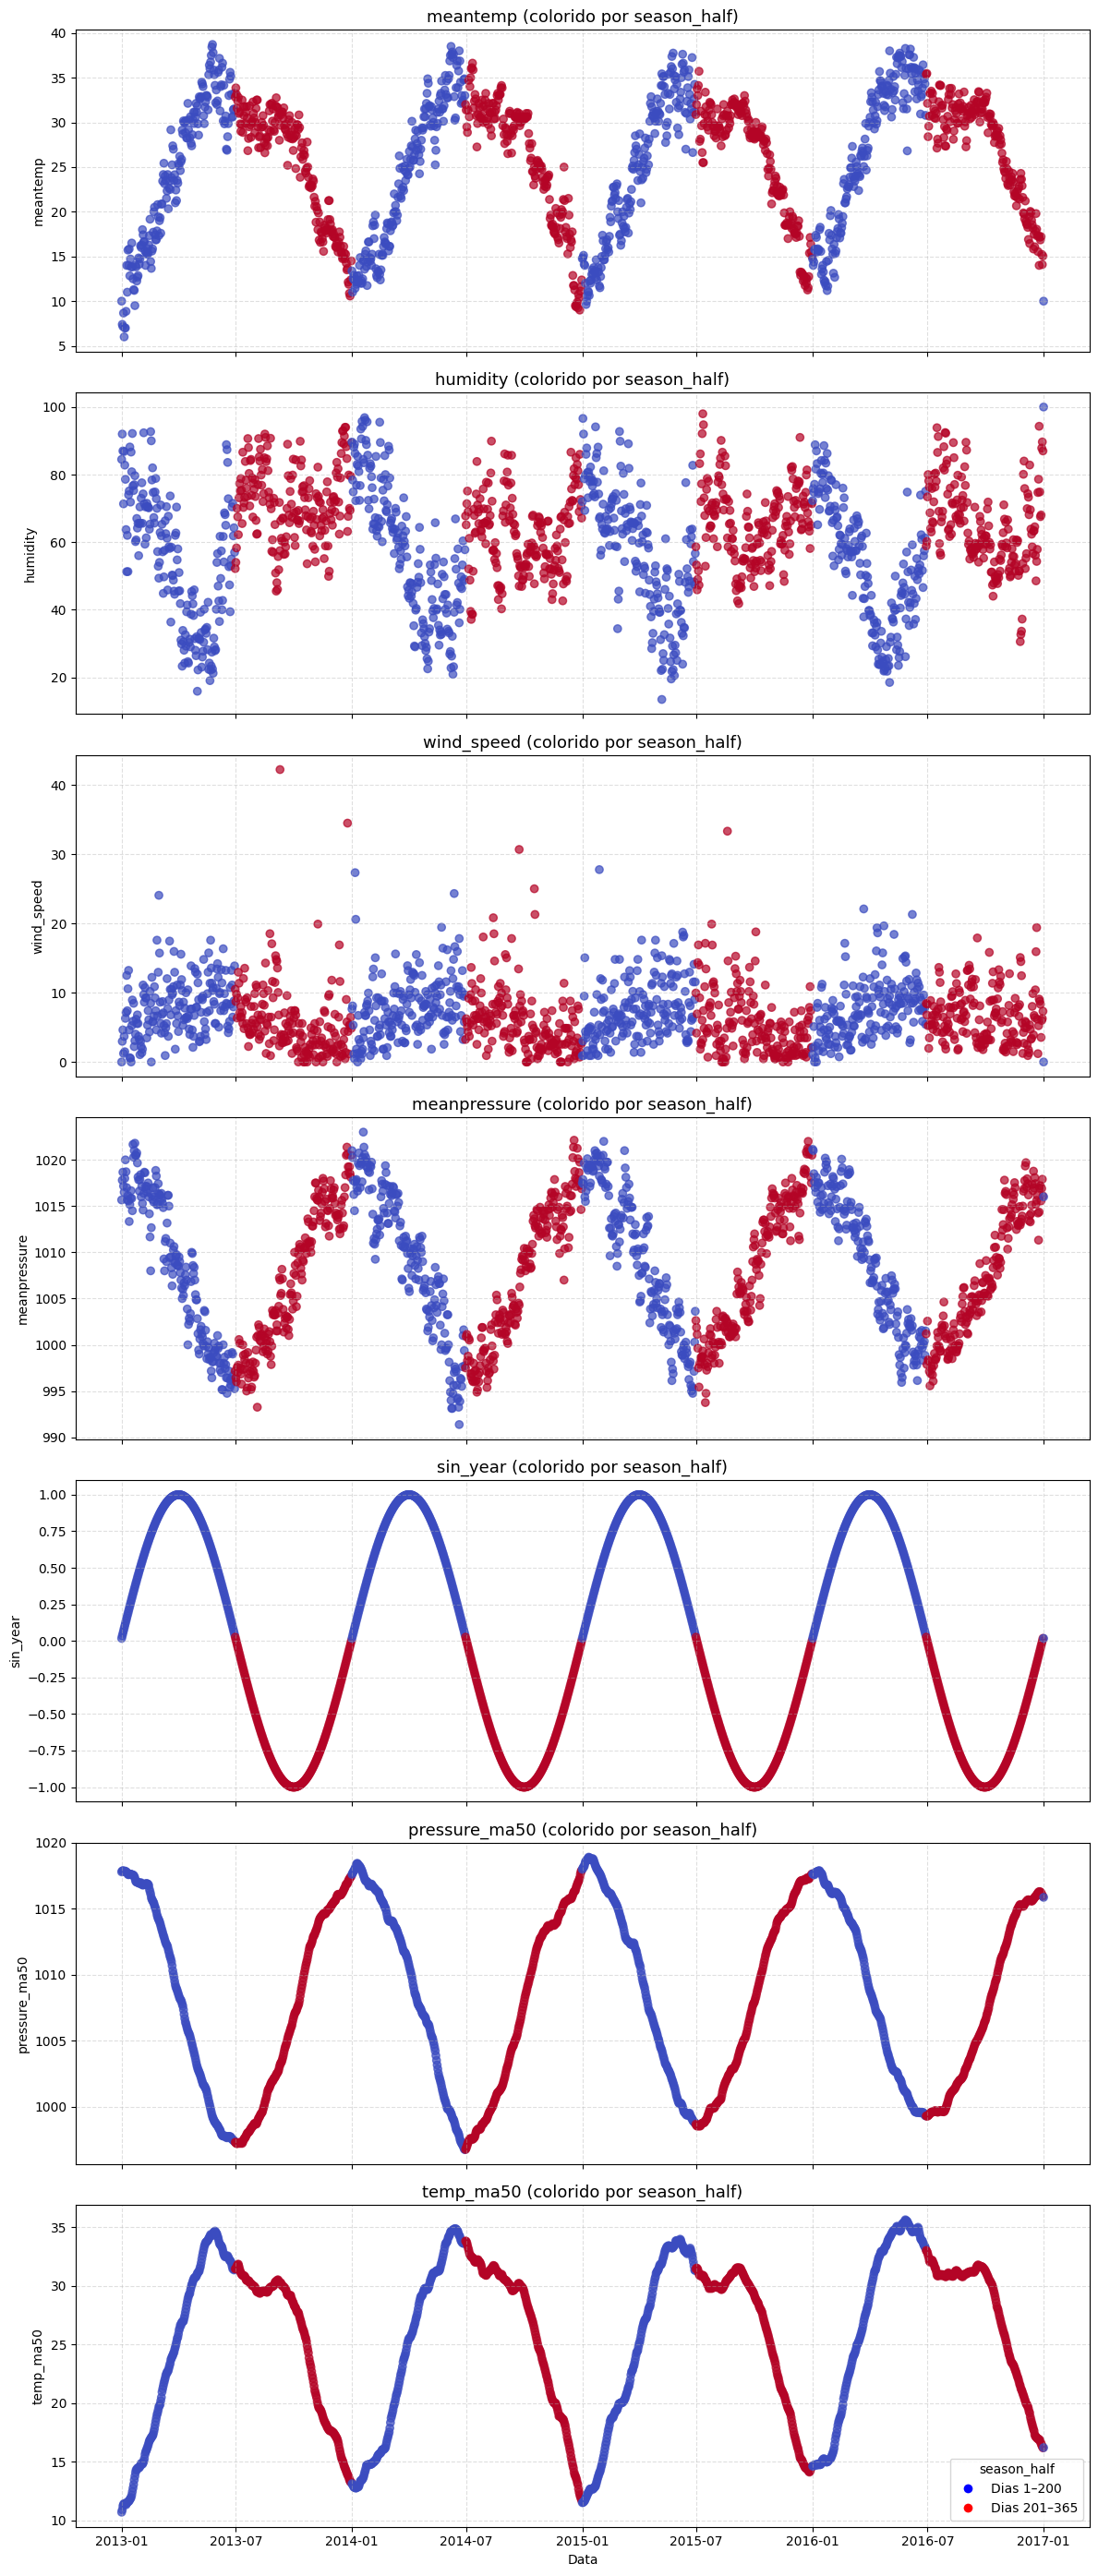

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Seleciona apenas as colunas numéricas (excluindo 'season_half' e 'dayofyear' se quiser)
numeric_cols = train_ds3.select_dtypes(include=['float64', 'int64']).columns.drop(["season_half", "dayofyear"], errors='ignore')

n = len(numeric_cols)
fig, axes = plt.subplots(n, 1, figsize=(12, 4*n), sharex=True)

if n == 1:
    axes = [axes]  # garante que axes seja iterável se só houver uma variável

for ax, col in zip(axes, numeric_cols):
    sc = ax.scatter(
        train_ds3["date"],
        train_ds3[col],
        c=train_ds3["season_half"],
        cmap="coolwarm",
        alpha=0.7
    )
    ax.set_title(f"{col} (colorido por season_half)", fontsize=13)
    ax.set_ylabel(col)
    ax.grid(True, linestyle="--", alpha=0.4)

# Legenda única
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Dias 1–200', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Dias 201–365', markerfacecolor='red', markersize=8)
]
axes[-1].legend(handles=handles, title="season_half")

axes[-1].set_xlabel("Data")
plt.tight_layout()
plt.show()
